In [1]:
import sys
import random
import numpy as np
import os
import sys
import gym
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf
from ns3gym import ns3env
#from ddqn import DDQN
from keras.backend.tensorflow_backend import set_session
from keras.utils import to_categorical
from utils.continuous_environments import Environment
from tqdm import tqdm
from dqnagent import Agent
from random import random, randrange
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
from utils.memory_buffer import MemoryBuffer
from matplotlib.colors import ListedColormap


Using TensorFlow backend.


In [2]:
nb_episodes = 200
max_env_steps = 95
batch_size = 128
with_per = True
dueling = True
consecutive_frames = 2

In [3]:
class Jupyter_DDQN:
    """ Deep Q-Learning Main Algorithm
    """
    lr = 2.5e-4
    gamma = 0.95
    epsilon = 0.8
    epsilon_decay = 0.99
    buffer_size = 20000
    
    def __init__(self, action_dim, state_dim,consecutive_frame,state_dim_init):
        """ Initialization
        """
        # Environment and DDQN parameters 
        consecutive_frames = consecutive_frame
        self.with_per = with_per
        self.action_dim = action_dim
        self.state_dim_init = state_dim_init
        self.state_dim = (consecutive_frames,) + state_dim

        if(len(state_dim) < 3):
            self.tau = 1e-2
        else:
            self.tau = 1.0
        # Create actor and critic networks
        self.agent = Agent(self.state_dim, action_dim, self.lr, self.tau, dueling)
        # Memory Buffer for Experience Replay
        self.buffer = MemoryBuffer(self.buffer_size, with_per)

    def policy_action(self, s):
        """ Apply an espilon-greedy policy to pick next action
        """
        if random() <= self.epsilon:
            return randrange(self.action_dim)
        else:
            return np.argmax(self.agent.predict(s)[0])

    def train_agent(self, batch_size):
        """ Train Q-network on batch sampled from the buffer
        """
        # Sample experience from memory buffer (optionally with PER)
        s, a, r, d, new_s, idx = self.buffer.sample_batch(batch_size)

        # Apply Bellman Equation on batch samples to train our DDQN
        q = self.agent.predict(s)
        next_q = self.agent.predict(new_s)
        q_targ = self.agent.target_predict(new_s)

        for i in range(s.shape[0]):
            old_q = q[i, a[i]]
            if d[i]:
                q[i, a[i]] = r[i]
            else:
                next_best_action = np.argmax(next_q[i,:])
                q[i, a[i]] = r[i] + self.gamma * q_targ[i, next_best_action]
            if(self.with_per):
                # Update PER Sum Tree
                self.buffer.update(idx[i], abs(old_q - q[i, a[i]]))
        # Train on batch
        self.agent.fit(s, q)
        # Decay epsilon
        self.epsilon *= self.epsilon_decay


    def train(self, env, filename):
        """ Main DDQN Training Algorithm
        """

        results = []
        time_history = []
        rew_history = []
        
        tqdm_e = tqdm(range(nb_episodes), desc='Score', leave=True, unit=" episodes")
        
        RL_data = {"RL-agent":[]}
        #create a list
        data_holder = RL_data["RL-agent"]
 
        #show_matrix = np.zeros([max_env_steps,self.action_dim])
        show_matrix = np.zeros([max_env_steps,self.state_dim_init])
        cmap0 = ListedColormap(['k', 'w'])
        cmap1 = ListedColormap(['k', 'w', 'r'])
        

        
        for e in tqdm_e:
            # Reset episode
            time, cumul_reward, done  = 0, 0, False
            old_state = env.reset()
            indexx = 1;
            pos_reward = 0
            neg_reward = 0
            while not done:
               
                #if args.render: env.render()
                # Actor picks an action (following the policy)
                a = self.policy_action(old_state)
                # Retrieve new state, reward, and whether the state is terminal
                new_state, r, done, _ = env.step(a)

                #pos_reward+=1
                #show_matrix[time,:] =  np.reshape(new_state, [1, self.action_dim])
                
                if(r >=0):
                    pos_reward+=1
                    show_matrix[time,:] =  np.reshape(new_state[1:16], [1,self.state_dim_init])
                else:
                    new_state_ = [x * 2 for x in new_state]
                    neg_reward+=1
                    show_matrix[time,:] =  np.reshape(new_state_[1:16], [1, self.state_dim_init])

                # Memorize for experience replay
                self.memorize(old_state, a, r, done, new_state)
                # Update current state
                old_state = new_state
                cumul_reward += r
                time += 1
                # Train DDQN and transfer weights to target network
                if(self.buffer.size() > batch_size):
                    self.train_agent(batch_size)
                    self.agent.transfer_weights()
                    
                indexx+=1
                if(indexx > max_env_steps):
                    break;    

            # Display score
            tqdm_e.set_description("Score: " + str(cumul_reward))
            tqdm_e.refresh()
            time_history.append(indexx)
            rew_history.append(cumul_reward)
            data_holder.append({'Time':indexx-1})
            data_holder.append({'Reward':cumul_reward})

            
            show_matrix1 = show_matrix 
            if(pos_reward == max_env_steps):    
                plt.matshow(np.transpose(show_matrix1),cmap=cmap0)
            else:
                plt.matshow(np.transpose(show_matrix1),cmap=cmap1)
            plt.show()
        
        
        with open(filename+'.txt', 'w') as outfile:  
            json.dump(data_holder, outfile)
        
        print("Plot Learning Performance")
        mpl.rcdefaults()
        mpl.rcParams.update({'font.size': 16})
            
        fig, ax = plt.subplots(figsize=(10,4))
        plt.grid(True, linestyle='--')
        plt.title('Learning Performance')
        plt.plot(range(len(time_history)), time_history, label='Steps', marker="^", linestyle=":")#, color='red')
        plt.plot(range(len(rew_history)), rew_history, label='Reward', marker="", linestyle="-")#, color='k')
        plt.xlabel('Episode')
        plt.ylabel('Time')
        plt.legend(prop={'size': 12})
            
        plt.savefig(filename+'.pdf', bbox_inches='tight')
        plt.show()

        return results

    def memorize(self, state, action, reward, done, new_state):
        """ Store experience in memory buffer
        """

        if(self.with_per):
            q_val = self.agent.predict(state)
            q_val_t = self.agent.target_predict(new_state)
            next_best_action = np.argmax(q_val)
            new_val = reward + self.gamma * q_val_t[0, next_best_action]
            td_error = abs(new_val - q_val)[0]
        else:
            td_error = 0
        self.buffer.memorize(state, action, reward, done, new_state, td_error)



In [4]:
env = Environment(gym.make('ns3-v0'), consecutive_frames)
state_dim_init = gym.make('ns3-v0').observation_space.shape[0]
state_dim = env.get_state_size()
action_dim = gym.make('ns3-v0').action_space.n
 
print("State Dim {}",state_dim)
print("Action Dim {}",action_dim)

Got new port for ns3gm interface:  6440
Got new port for ns3gm interface:  8050
Got new port for ns3gm interface:  7033
State Dim {} (16,)
Action Dim {} 16


In [5]:
algo = Jupyter_DDQN(action_dim, state_dim,consecutive_frames,state_dim_init)

Score: -89.0:   0%|          | 0/200 [00:00<?, ? episodes/s]

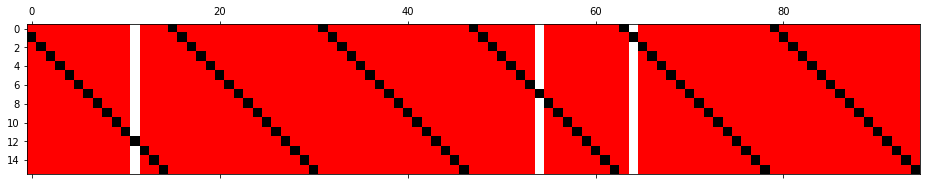

Score: -89.0:   0%|          | 1/200 [00:00<00:42,  4.72 episodes/s]

Got new port for ns3gm interface:  5600


Score: -87.0:   0%|          | 1/200 [00:04<00:42,  4.72 episodes/s]

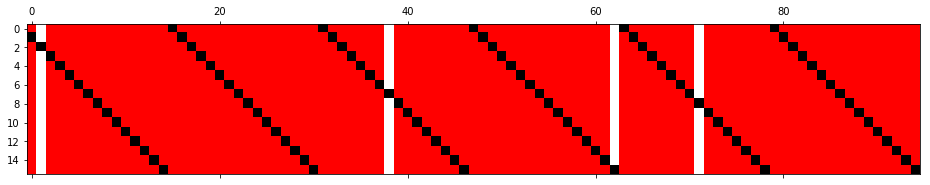

Score: -87.0:   1%|          | 2/200 [00:04<04:20,  1.31s/ episodes]

Got new port for ns3gm interface:  7417


Score: -79.0:   1%|          | 2/200 [00:07<04:20,  1.31s/ episodes]

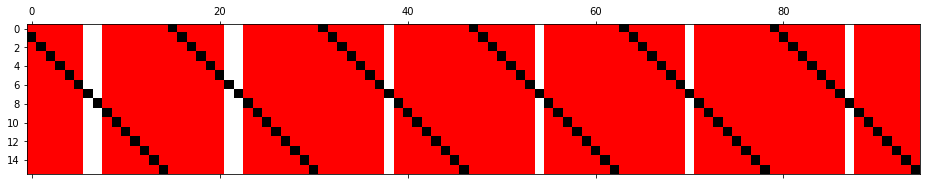

Score: -79.0:   2%|▏         | 3/200 [00:08<06:51,  2.09s/ episodes]

Got new port for ns3gm interface:  9662


Score: -29.0:   2%|▏         | 3/200 [00:11<06:51,  2.09s/ episodes]

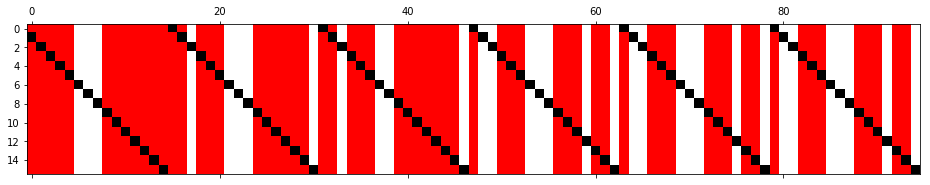

Score: -29.0:   2%|▏         | 4/200 [00:11<08:38,  2.65s/ episodes]

Got new port for ns3gm interface:  7089


Score: -11.0:   2%|▏         | 4/200 [00:15<08:38,  2.65s/ episodes]

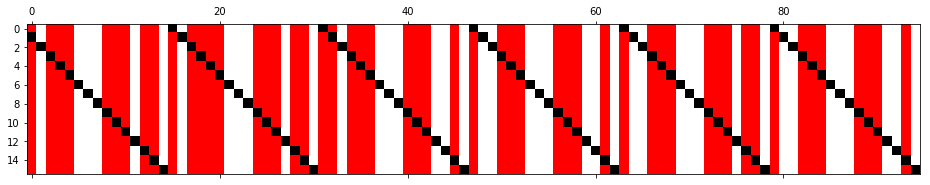

Score: -11.0:   2%|▎         | 5/200 [00:15<09:46,  3.01s/ episodes]

Got new port for ns3gm interface:  8200


Score: 7.0:   2%|▎         | 5/200 [00:19<09:46,  3.01s/ episodes]  

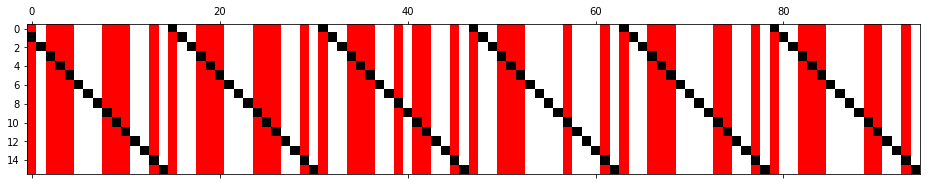

Score: 7.0:   3%|▎         | 6/200 [00:19<10:38,  3.29s/ episodes]

Got new port for ns3gm interface:  6691


Score: 13.0:   3%|▎         | 6/200 [00:23<10:38,  3.29s/ episodes]

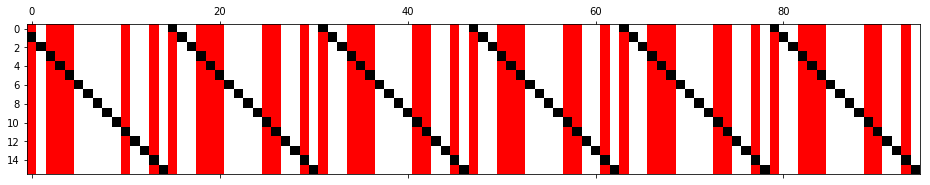

Score: 13.0:   4%|▎         | 7/200 [00:23<11:08,  3.46s/ episodes]

Got new port for ns3gm interface:  7599


Score: 17.0:   4%|▎         | 7/200 [00:27<11:08,  3.46s/ episodes]

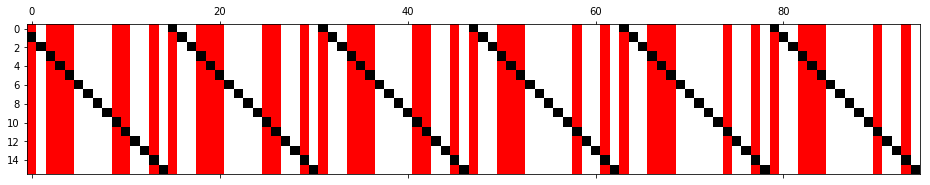

Score: 17.0:   4%|▍         | 8/200 [00:27<11:29,  3.59s/ episodes]

Got new port for ns3gm interface:  6504


Score: 35.0:   4%|▍         | 8/200 [00:31<11:29,  3.59s/ episodes]

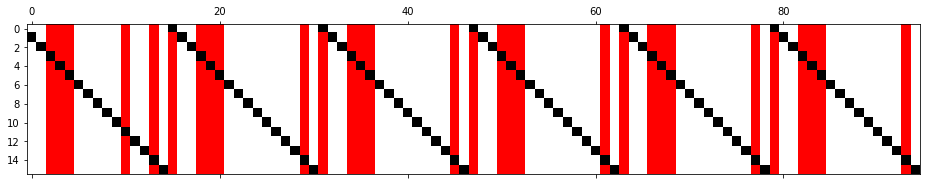

Score: 35.0:   4%|▍         | 9/200 [00:31<11:42,  3.68s/ episodes]

Got new port for ns3gm interface:  9686


Score: 37.0:   4%|▍         | 9/200 [00:35<11:42,  3.68s/ episodes]

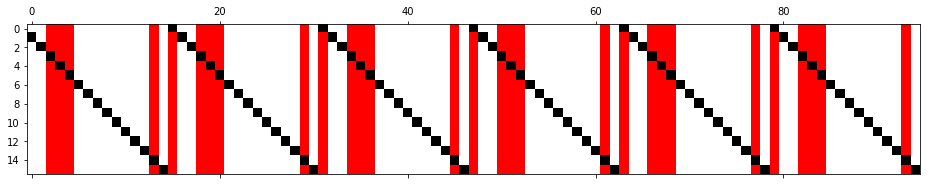

Score: 37.0:   5%|▌         | 10/200 [00:35<11:48,  3.73s/ episodes]

Got new port for ns3gm interface:  8906


Score: 37.0:   5%|▌         | 10/200 [00:39<11:48,  3.73s/ episodes]

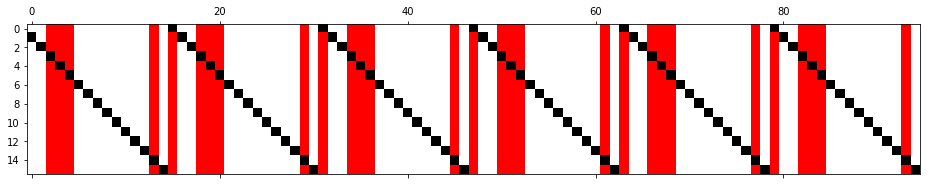

Score: 37.0:   6%|▌         | 11/200 [00:39<11:57,  3.80s/ episodes]

Got new port for ns3gm interface:  8137


Score: 37.0:   6%|▌         | 11/200 [00:43<11:57,  3.80s/ episodes]

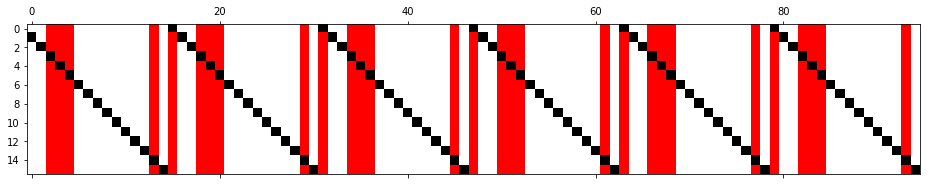

Score: 37.0:   6%|▌         | 12/200 [00:43<11:59,  3.83s/ episodes]

Got new port for ns3gm interface:  8401


Score: 37.0:   6%|▌         | 12/200 [00:46<11:59,  3.83s/ episodes]

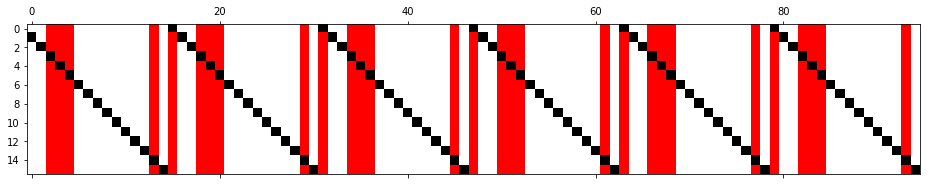

Score: 37.0:   6%|▋         | 13/200 [00:46<11:58,  3.84s/ episodes]

Got new port for ns3gm interface:  6827


Score: 37.0:   6%|▋         | 13/200 [00:50<11:58,  3.84s/ episodes]

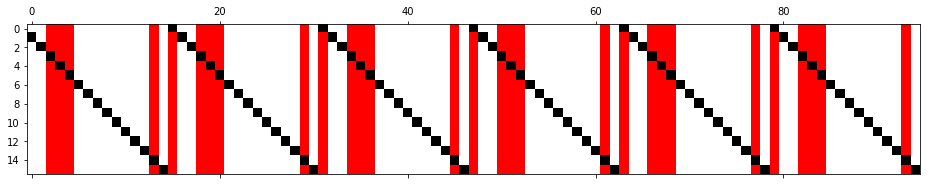

Score: 37.0:   7%|▋         | 14/200 [00:50<11:54,  3.84s/ episodes]

Got new port for ns3gm interface:  7690


Score: 37.0:   7%|▋         | 14/200 [00:54<11:54,  3.84s/ episodes]

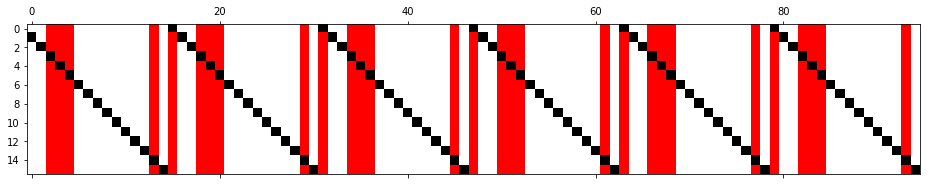

Score: 37.0:   8%|▊         | 15/200 [00:54<11:52,  3.85s/ episodes]

Got new port for ns3gm interface:  5329


Score: 37.0:   8%|▊         | 15/200 [00:58<11:52,  3.85s/ episodes]

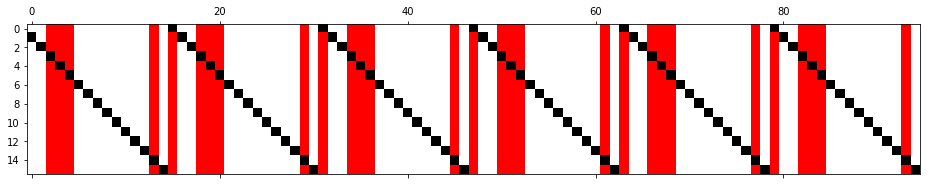

Score: 37.0:   8%|▊         | 16/200 [00:58<11:47,  3.85s/ episodes]

Got new port for ns3gm interface:  8966


Score: 37.0:   8%|▊         | 16/200 [01:02<11:47,  3.85s/ episodes]

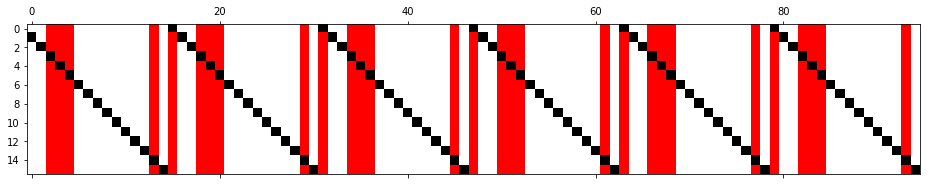

Score: 37.0:   8%|▊         | 17/200 [01:02<11:44,  3.85s/ episodes]

Got new port for ns3gm interface:  6402


Score: 37.0:   8%|▊         | 17/200 [01:06<11:44,  3.85s/ episodes]

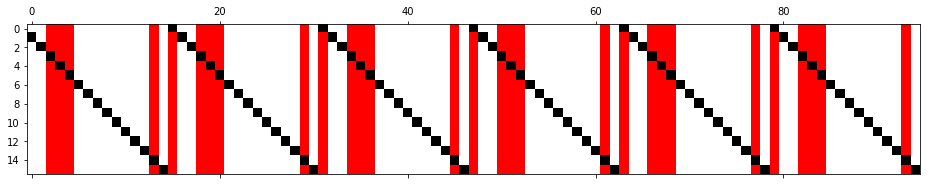

Score: 37.0:   9%|▉         | 18/200 [01:06<11:42,  3.86s/ episodes]

Got new port for ns3gm interface:  6099


Score: 37.0:   9%|▉         | 18/200 [01:10<11:42,  3.86s/ episodes]

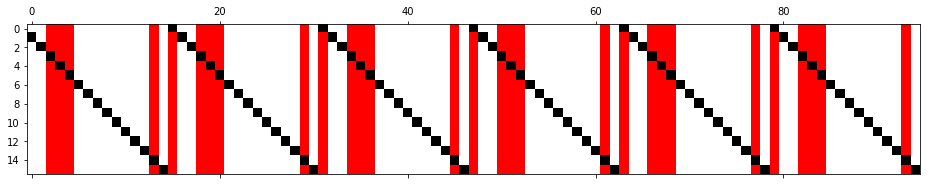

Score: 37.0:  10%|▉         | 19/200 [01:10<11:38,  3.86s/ episodes]

Got new port for ns3gm interface:  5542


Score: 37.0:  10%|▉         | 19/200 [01:13<11:38,  3.86s/ episodes]

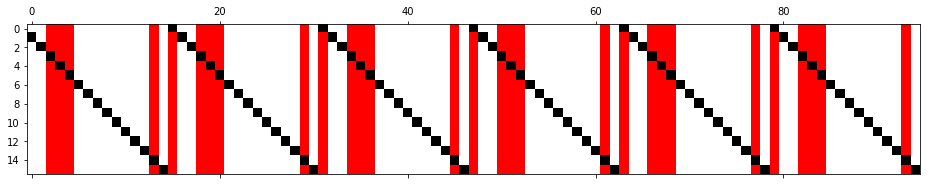

Score: 37.0:  10%|█         | 20/200 [01:13<11:34,  3.86s/ episodes]

Got new port for ns3gm interface:  7042


Score: 37.0:  10%|█         | 20/200 [01:17<11:34,  3.86s/ episodes]

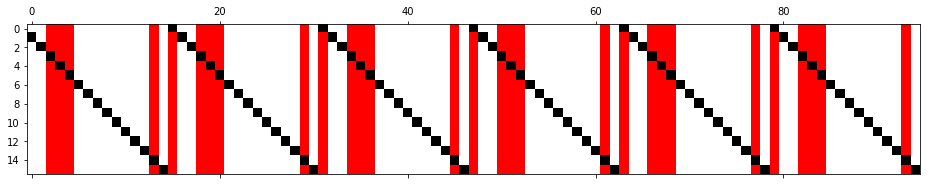

Score: 37.0:  10%|█         | 21/200 [01:17<11:29,  3.85s/ episodes]

Got new port for ns3gm interface:  7160


Score: 37.0:  10%|█         | 21/200 [01:21<11:29,  3.85s/ episodes]

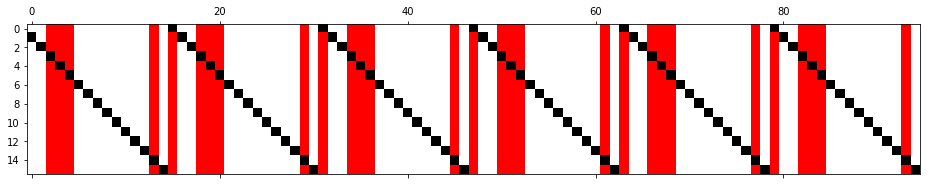

Score: 37.0:  11%|█         | 22/200 [01:21<11:27,  3.86s/ episodes]

Got new port for ns3gm interface:  5405


Score: 37.0:  11%|█         | 22/200 [01:25<11:27,  3.86s/ episodes]

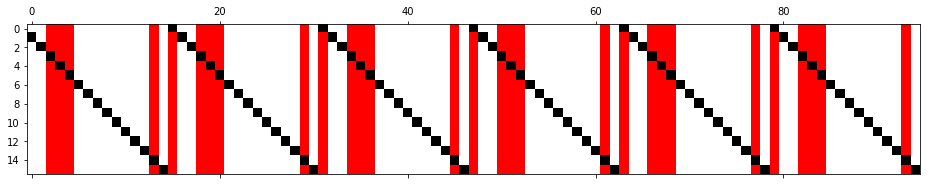

Score: 37.0:  12%|█▏        | 23/200 [01:25<11:26,  3.88s/ episodes]

Got new port for ns3gm interface:  6843


Score: 37.0:  12%|█▏        | 23/200 [01:29<11:26,  3.88s/ episodes]

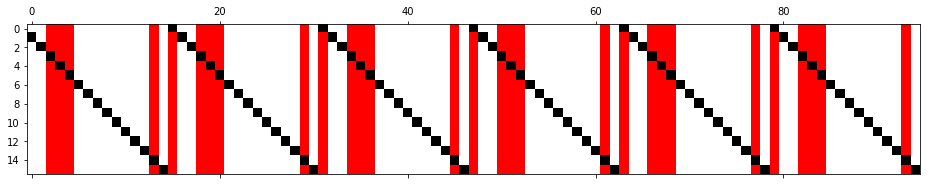

Score: 37.0:  12%|█▏        | 24/200 [01:29<11:21,  3.87s/ episodes]

Got new port for ns3gm interface:  8070


Score: 37.0:  12%|█▏        | 24/200 [01:33<11:21,  3.87s/ episodes]

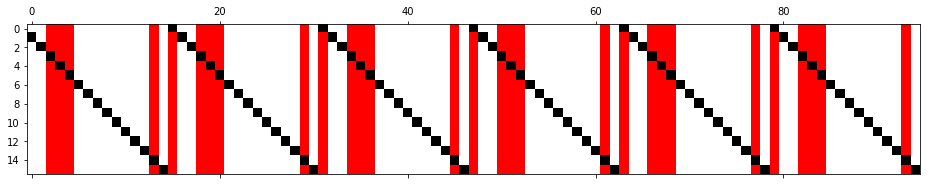

Score: 37.0:  12%|█▎        | 25/200 [01:33<11:18,  3.88s/ episodes]

Got new port for ns3gm interface:  6768


Score: 37.0:  12%|█▎        | 25/200 [01:37<11:18,  3.88s/ episodes]

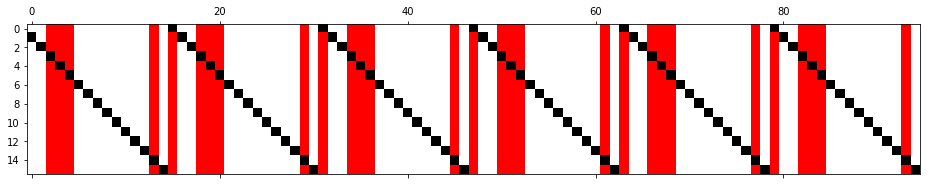

Score: 37.0:  13%|█▎        | 26/200 [01:37<11:17,  3.90s/ episodes]

Got new port for ns3gm interface:  7245


Score: 37.0:  13%|█▎        | 26/200 [01:41<11:17,  3.90s/ episodes]

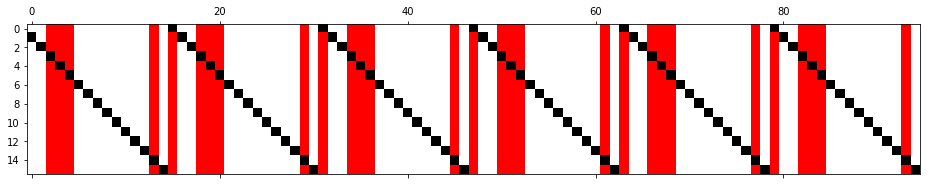

Score: 37.0:  14%|█▎        | 27/200 [01:41<11:19,  3.93s/ episodes]

Got new port for ns3gm interface:  7069


Score: 37.0:  14%|█▎        | 27/200 [01:45<11:19,  3.93s/ episodes]

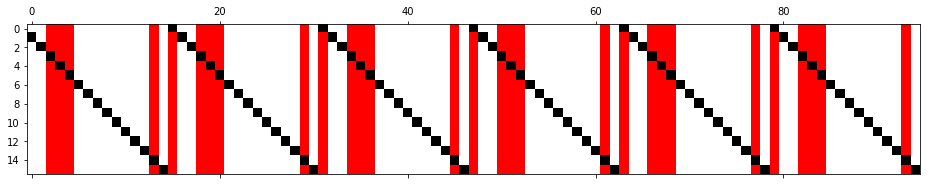

Score: 37.0:  14%|█▍        | 28/200 [01:45<11:23,  3.98s/ episodes]

Got new port for ns3gm interface:  7822


Score: 37.0:  14%|█▍        | 28/200 [01:49<11:23,  3.98s/ episodes]

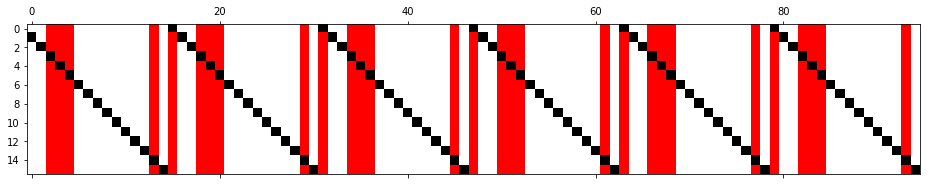

Score: 37.0:  14%|█▍        | 29/200 [01:49<11:25,  4.01s/ episodes]

Got new port for ns3gm interface:  6220


Score: 37.0:  14%|█▍        | 29/200 [01:53<11:25,  4.01s/ episodes]

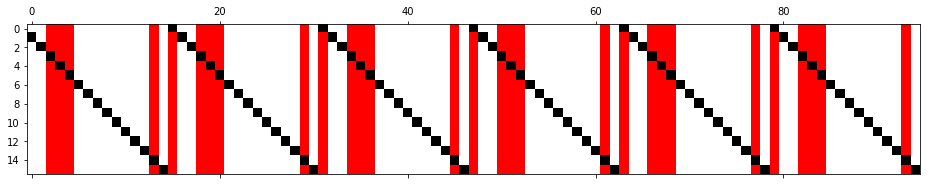

Score: 37.0:  15%|█▌        | 30/200 [01:53<11:25,  4.03s/ episodes]

Got new port for ns3gm interface:  8042


Score: 37.0:  15%|█▌        | 30/200 [01:57<11:25,  4.03s/ episodes]

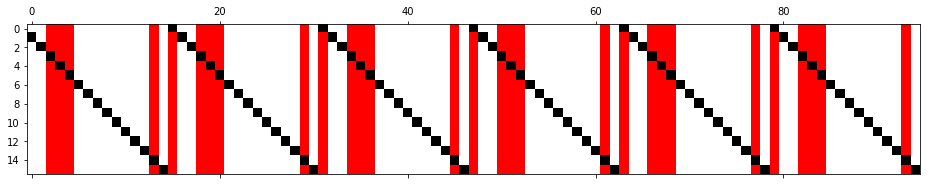

Score: 37.0:  16%|█▌        | 31/200 [01:57<11:24,  4.05s/ episodes]

Got new port for ns3gm interface:  7865


Score: 37.0:  16%|█▌        | 31/200 [02:01<11:24,  4.05s/ episodes]

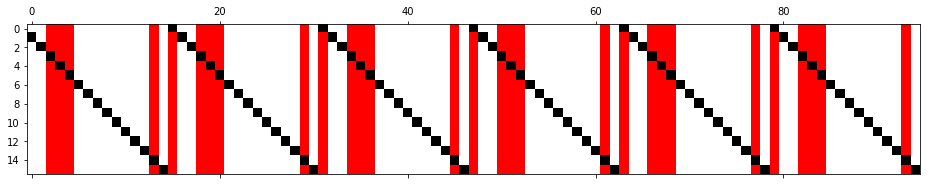

Score: 37.0:  16%|█▌        | 32/200 [02:01<11:21,  4.05s/ episodes]

Got new port for ns3gm interface:  6572


Score: 37.0:  16%|█▌        | 32/200 [02:05<11:21,  4.05s/ episodes]

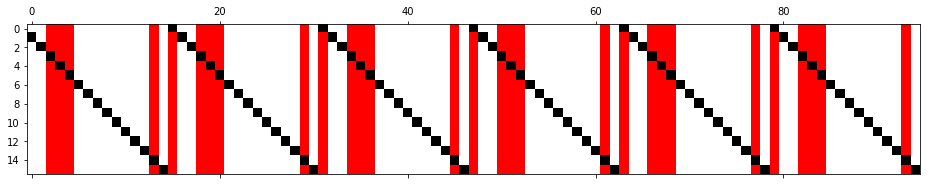

Score: 37.0:  16%|█▋        | 33/200 [02:05<11:19,  4.07s/ episodes]

Got new port for ns3gm interface:  6556


Score: 37.0:  16%|█▋        | 33/200 [02:09<11:19,  4.07s/ episodes]

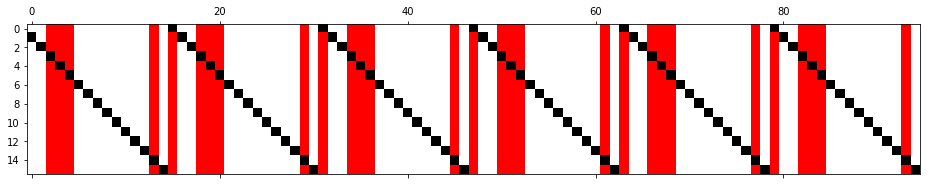

Score: 37.0:  17%|█▋        | 34/200 [02:09<11:15,  4.07s/ episodes]

Got new port for ns3gm interface:  9730


Score: 37.0:  17%|█▋        | 34/200 [02:13<11:15,  4.07s/ episodes]

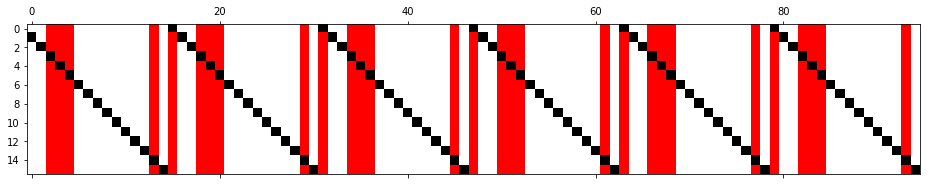

Score: 37.0:  18%|█▊        | 35/200 [02:13<11:11,  4.07s/ episodes]

Got new port for ns3gm interface:  9680


Score: 37.0:  18%|█▊        | 35/200 [02:18<11:11,  4.07s/ episodes]

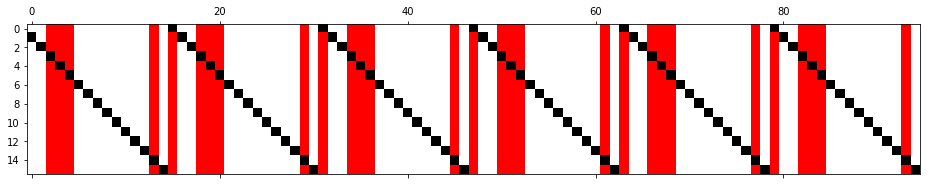

Score: 37.0:  18%|█▊        | 36/200 [02:18<11:11,  4.10s/ episodes]

Got new port for ns3gm interface:  7861


Score: 37.0:  18%|█▊        | 36/200 [02:22<11:11,  4.10s/ episodes]

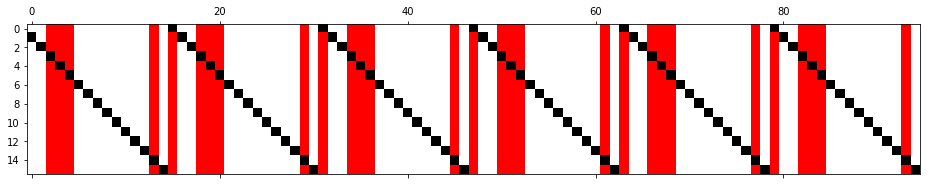

Score: 37.0:  18%|█▊        | 37/200 [02:22<11:08,  4.10s/ episodes]

Got new port for ns3gm interface:  7188


Score: 37.0:  18%|█▊        | 37/200 [02:26<11:08,  4.10s/ episodes]

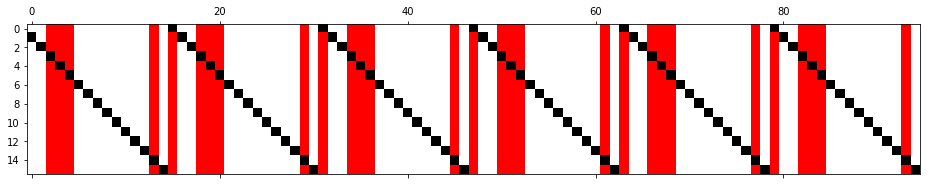

Score: 37.0:  19%|█▉        | 38/200 [02:26<11:03,  4.10s/ episodes]

Got new port for ns3gm interface:  5528


Score: 37.0:  19%|█▉        | 38/200 [02:30<11:03,  4.10s/ episodes]

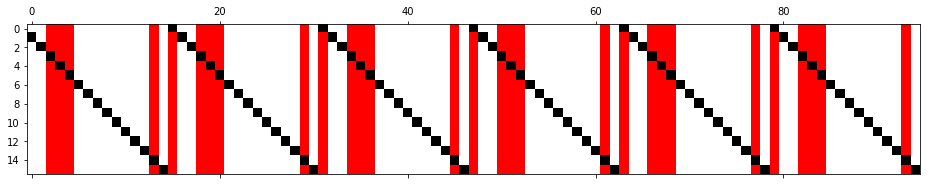

Score: 37.0:  20%|█▉        | 39/200 [02:30<10:58,  4.09s/ episodes]

Got new port for ns3gm interface:  9567


Score: 37.0:  20%|█▉        | 39/200 [02:34<10:58,  4.09s/ episodes]

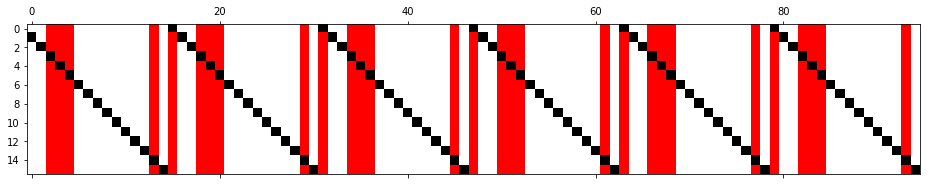

Score: 37.0:  20%|██        | 40/200 [02:34<10:57,  4.11s/ episodes]

Got new port for ns3gm interface:  7210


Score: 37.0:  20%|██        | 40/200 [02:38<10:57,  4.11s/ episodes]

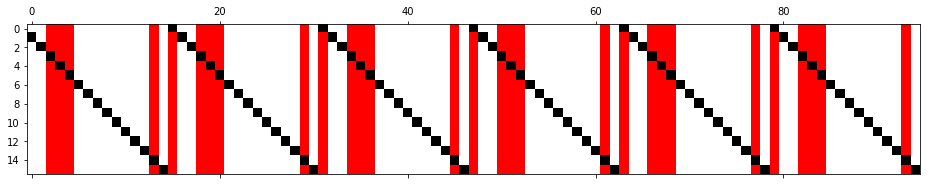

Score: 37.0:  20%|██        | 41/200 [02:38<10:52,  4.10s/ episodes]

Got new port for ns3gm interface:  6057


Score: 37.0:  20%|██        | 41/200 [02:42<10:52,  4.10s/ episodes]

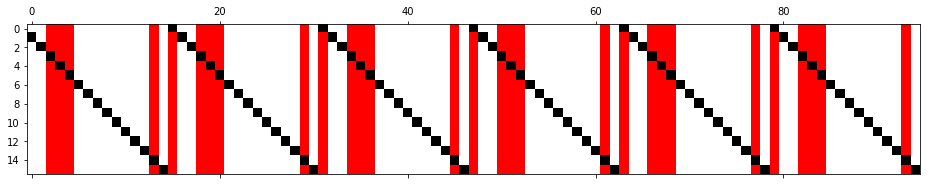

Score: 37.0:  21%|██        | 42/200 [02:42<10:50,  4.12s/ episodes]

Got new port for ns3gm interface:  8008


Score: 37.0:  21%|██        | 42/200 [02:46<10:50,  4.12s/ episodes]

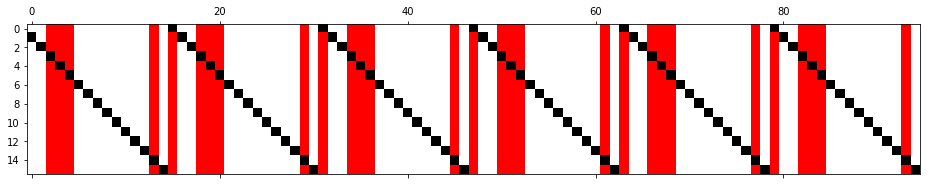

Score: 37.0:  22%|██▏       | 43/200 [02:46<10:44,  4.10s/ episodes]

Got new port for ns3gm interface:  6152


Score: 37.0:  22%|██▏       | 43/200 [02:50<10:44,  4.10s/ episodes]

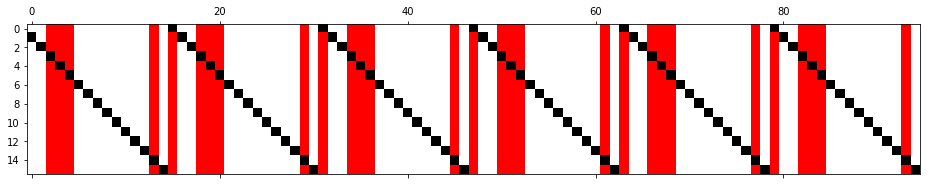

Score: 37.0:  22%|██▏       | 44/200 [02:51<10:44,  4.13s/ episodes]

Got new port for ns3gm interface:  5699


Score: 37.0:  22%|██▏       | 44/200 [02:55<10:44,  4.13s/ episodes]

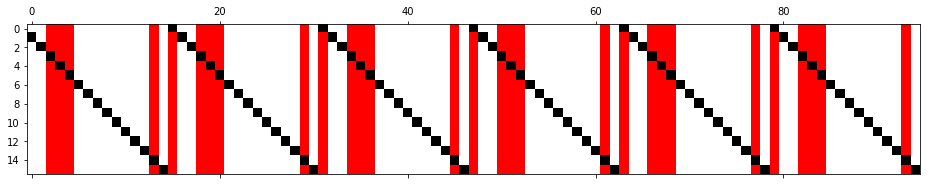

Score: 37.0:  22%|██▎       | 45/200 [02:55<10:36,  4.11s/ episodes]

Got new port for ns3gm interface:  7817


Score: 37.0:  22%|██▎       | 45/200 [02:59<10:36,  4.11s/ episodes]

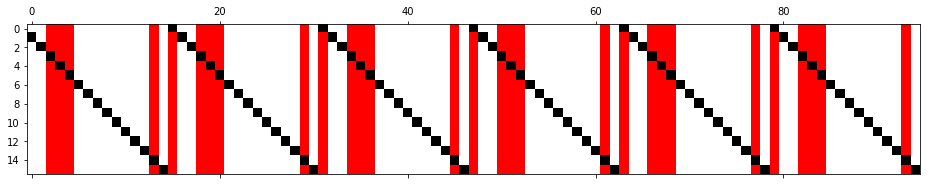

Score: 37.0:  23%|██▎       | 46/200 [02:59<10:32,  4.11s/ episodes]

Got new port for ns3gm interface:  5684


Score: 37.0:  23%|██▎       | 46/200 [03:03<10:32,  4.11s/ episodes]

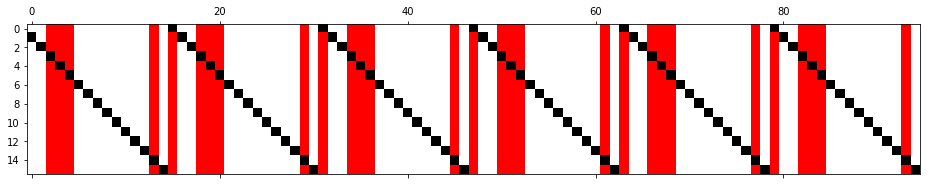

Score: 37.0:  24%|██▎       | 47/200 [03:03<10:28,  4.11s/ episodes]

Got new port for ns3gm interface:  9110


Score: 37.0:  24%|██▎       | 47/200 [03:07<10:28,  4.11s/ episodes]

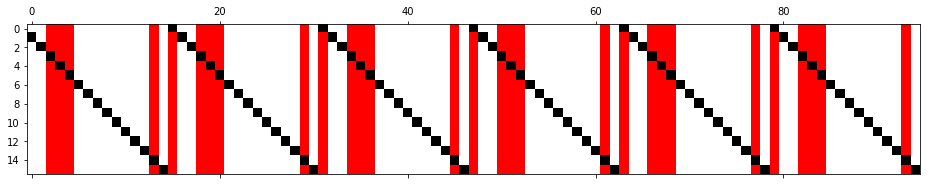

Score: 37.0:  24%|██▍       | 48/200 [03:07<10:27,  4.13s/ episodes]

Got new port for ns3gm interface:  8465


Score: 37.0:  24%|██▍       | 48/200 [03:11<10:27,  4.13s/ episodes]

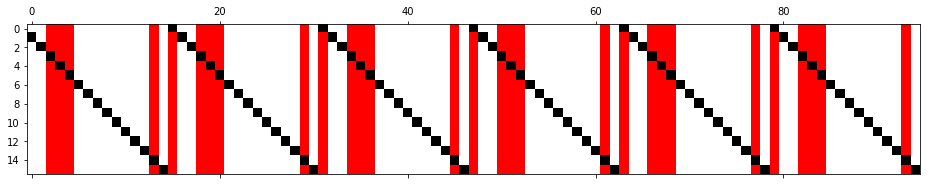

Score: 37.0:  24%|██▍       | 49/200 [03:11<10:24,  4.13s/ episodes]

Got new port for ns3gm interface:  7885


Score: 37.0:  24%|██▍       | 49/200 [03:15<10:24,  4.13s/ episodes]

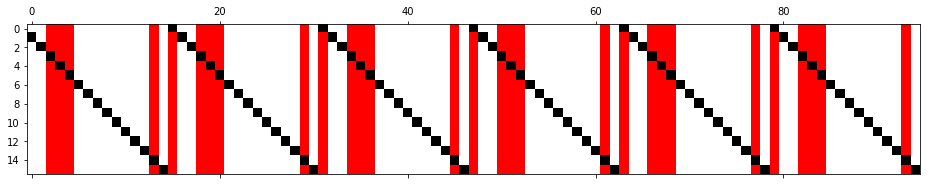

Score: 37.0:  25%|██▌       | 50/200 [03:15<10:18,  4.12s/ episodes]

Got new port for ns3gm interface:  6313


Score: 37.0:  25%|██▌       | 50/200 [03:19<10:18,  4.12s/ episodes]

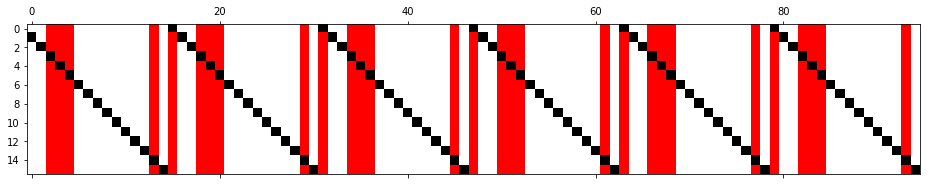

Score: 37.0:  26%|██▌       | 51/200 [03:19<10:12,  4.11s/ episodes]

Got new port for ns3gm interface:  5782


Score: 37.0:  26%|██▌       | 51/200 [03:23<10:12,  4.11s/ episodes]

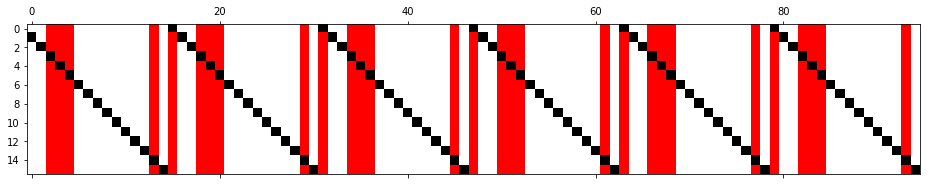

Score: 37.0:  26%|██▌       | 52/200 [03:23<10:09,  4.12s/ episodes]

Got new port for ns3gm interface:  7846


Score: 37.0:  26%|██▌       | 52/200 [03:28<10:09,  4.12s/ episodes]

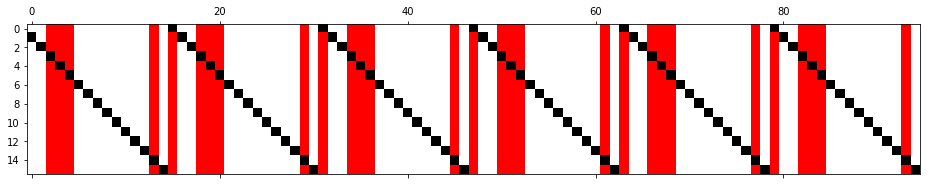

Score: 37.0:  26%|██▋       | 53/200 [03:28<10:04,  4.12s/ episodes]

Got new port for ns3gm interface:  8758


Score: 37.0:  26%|██▋       | 53/200 [03:32<10:04,  4.12s/ episodes]

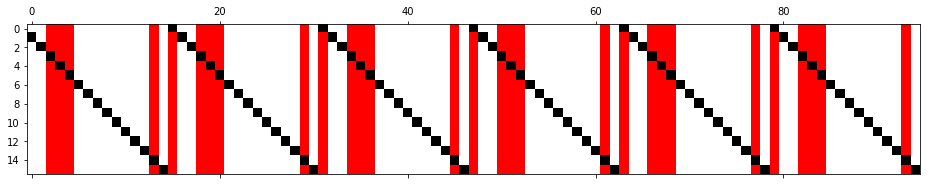

Score: 37.0:  27%|██▋       | 54/200 [03:32<09:57,  4.09s/ episodes]

Got new port for ns3gm interface:  9555


Score: 37.0:  27%|██▋       | 54/200 [03:36<09:57,  4.09s/ episodes]

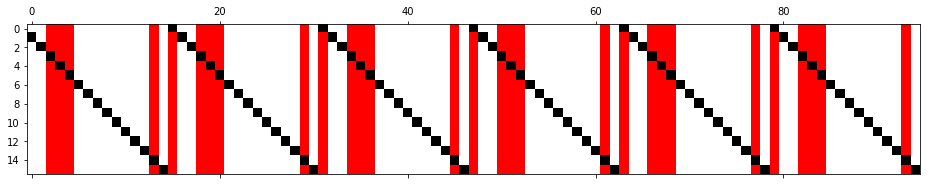

Score: 37.0:  28%|██▊       | 55/200 [03:36<09:53,  4.10s/ episodes]

Got new port for ns3gm interface:  5998


Score: 37.0:  28%|██▊       | 55/200 [03:40<09:53,  4.10s/ episodes]

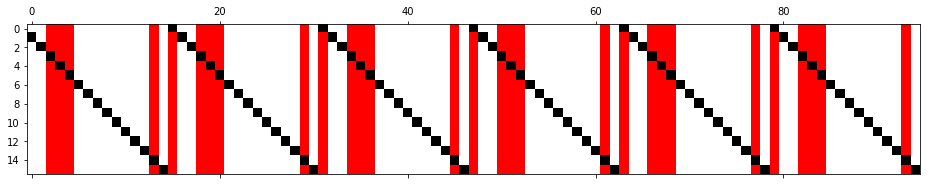

Score: 37.0:  28%|██▊       | 56/200 [03:40<09:48,  4.09s/ episodes]

Got new port for ns3gm interface:  6495


Score: 37.0:  28%|██▊       | 56/200 [03:44<09:48,  4.09s/ episodes]

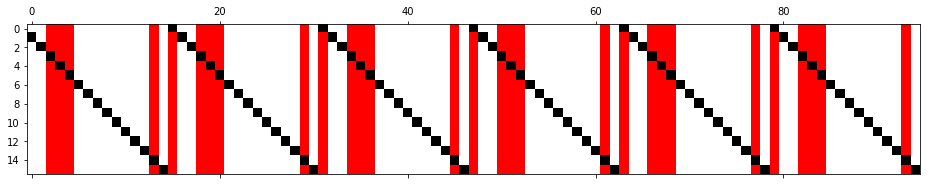

Score: 37.0:  28%|██▊       | 57/200 [03:44<09:42,  4.08s/ episodes]

Got new port for ns3gm interface:  8196


Score: 37.0:  28%|██▊       | 57/200 [03:48<09:42,  4.08s/ episodes]

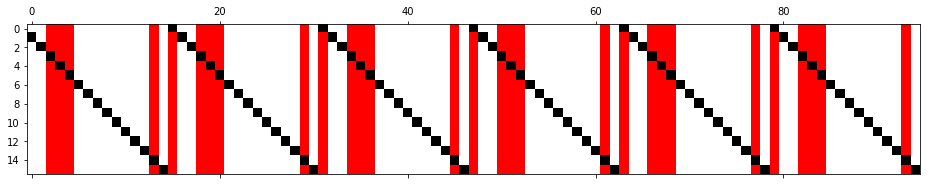

Score: 37.0:  29%|██▉       | 58/200 [03:48<09:38,  4.07s/ episodes]

Got new port for ns3gm interface:  6733


Score: 37.0:  29%|██▉       | 58/200 [03:52<09:38,  4.07s/ episodes]

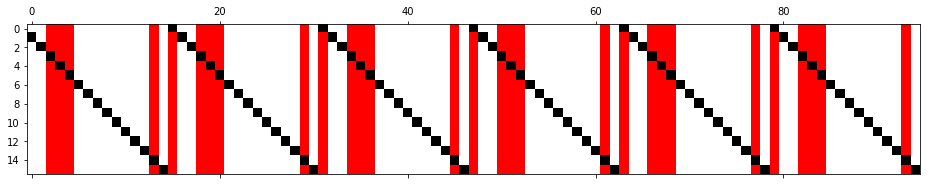

Score: 37.0:  30%|██▉       | 59/200 [03:52<09:34,  4.08s/ episodes]

Got new port for ns3gm interface:  9855


Score: 37.0:  30%|██▉       | 59/200 [03:56<09:34,  4.08s/ episodes]

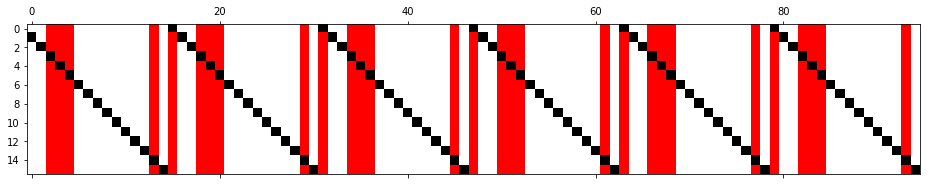

Score: 37.0:  30%|███       | 60/200 [03:56<09:32,  4.09s/ episodes]

Got new port for ns3gm interface:  8438


Score: 37.0:  30%|███       | 60/200 [04:00<09:32,  4.09s/ episodes]

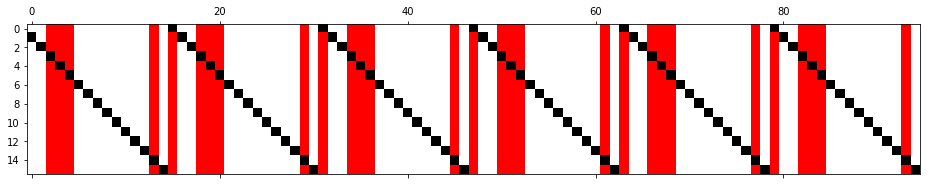

Score: 37.0:  30%|███       | 61/200 [04:00<09:27,  4.08s/ episodes]

Got new port for ns3gm interface:  5892


Score: 37.0:  30%|███       | 61/200 [04:04<09:27,  4.08s/ episodes]

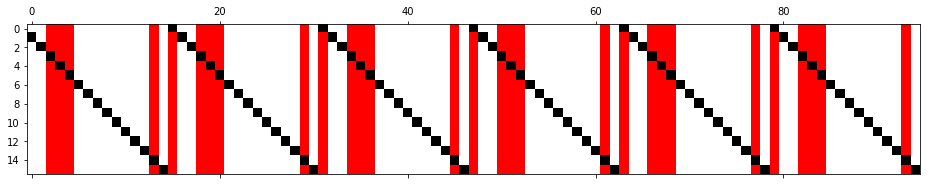

Score: 37.0:  31%|███       | 62/200 [04:04<09:26,  4.10s/ episodes]

Got new port for ns3gm interface:  5877


Score: 37.0:  31%|███       | 62/200 [04:08<09:26,  4.10s/ episodes]

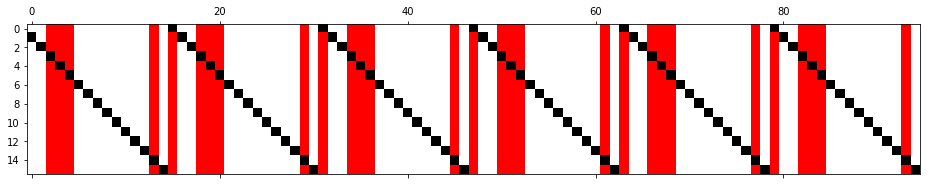

Score: 37.0:  32%|███▏      | 63/200 [04:08<09:21,  4.10s/ episodes]

Got new port for ns3gm interface:  7913


Score: 37.0:  32%|███▏      | 63/200 [04:12<09:21,  4.10s/ episodes]

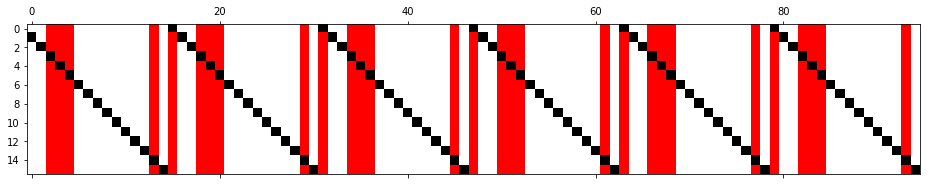

Score: 37.0:  32%|███▏      | 64/200 [04:13<09:17,  4.10s/ episodes]

Got new port for ns3gm interface:  6581


Score: 37.0:  32%|███▏      | 64/200 [04:17<09:17,  4.10s/ episodes]

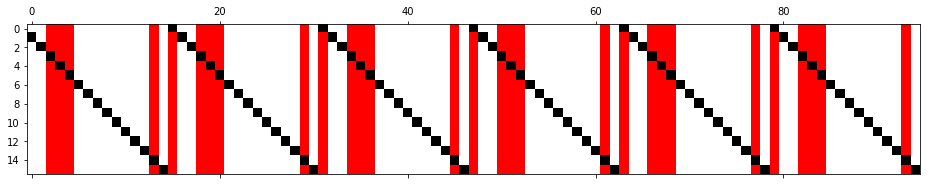

Score: 37.0:  32%|███▎      | 65/200 [04:17<09:15,  4.11s/ episodes]

Got new port for ns3gm interface:  8145


Score: 37.0:  32%|███▎      | 65/200 [04:21<09:15,  4.11s/ episodes]

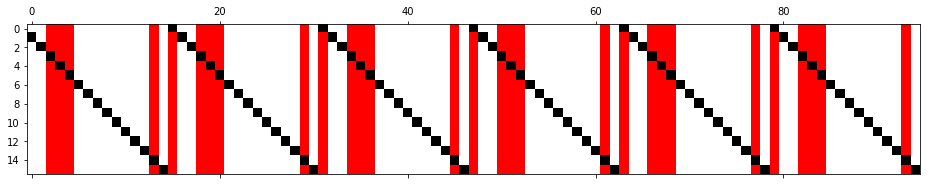

Score: 37.0:  33%|███▎      | 66/200 [04:21<09:12,  4.12s/ episodes]

Got new port for ns3gm interface:  6280


Score: 37.0:  33%|███▎      | 66/200 [04:25<09:12,  4.12s/ episodes]

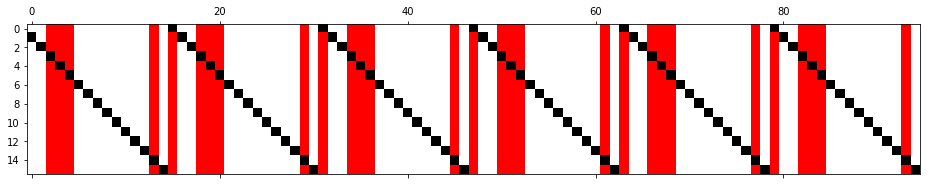

Score: 37.0:  34%|███▎      | 67/200 [04:25<09:08,  4.12s/ episodes]

Got new port for ns3gm interface:  8374


Score: 37.0:  34%|███▎      | 67/200 [04:29<09:08,  4.12s/ episodes]

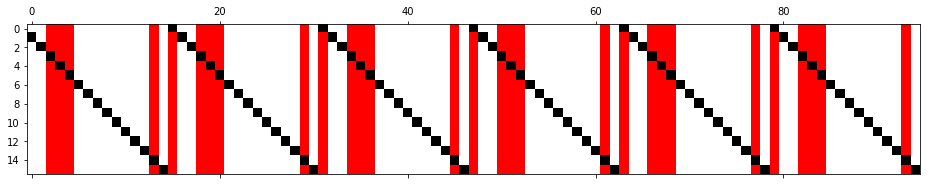

Score: 37.0:  34%|███▍      | 68/200 [04:29<09:01,  4.10s/ episodes]

Got new port for ns3gm interface:  7400


Score: 37.0:  34%|███▍      | 68/200 [04:33<09:01,  4.10s/ episodes]

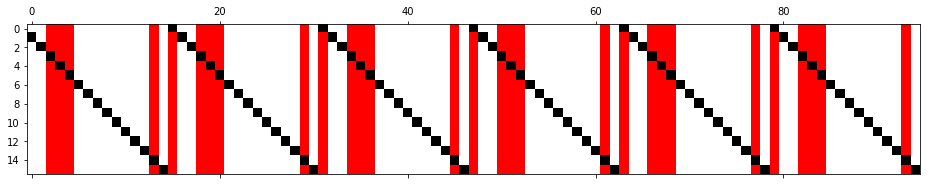

Score: 37.0:  34%|███▍      | 69/200 [04:33<08:57,  4.10s/ episodes]

Got new port for ns3gm interface:  6475


Score: 37.0:  34%|███▍      | 69/200 [04:37<08:57,  4.10s/ episodes]

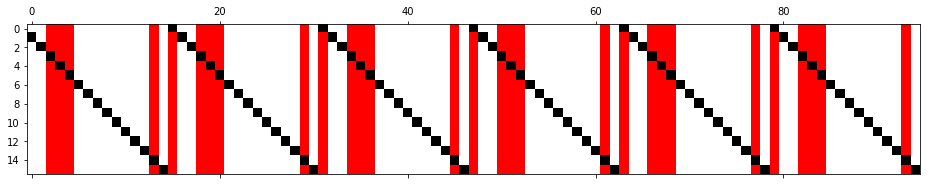

Score: 37.0:  35%|███▌      | 70/200 [04:37<08:56,  4.13s/ episodes]

Got new port for ns3gm interface:  6566


Score: 37.0:  35%|███▌      | 70/200 [04:41<08:56,  4.13s/ episodes]

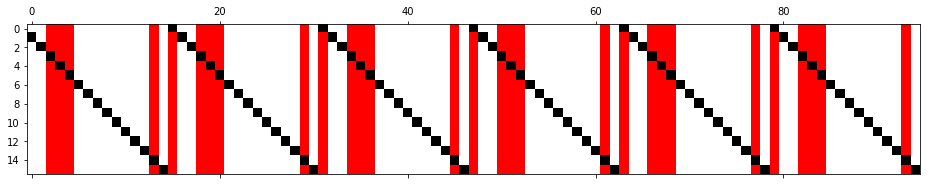

Score: 37.0:  36%|███▌      | 71/200 [04:41<08:52,  4.13s/ episodes]

Got new port for ns3gm interface:  5950


Score: 37.0:  36%|███▌      | 71/200 [04:45<08:52,  4.13s/ episodes]

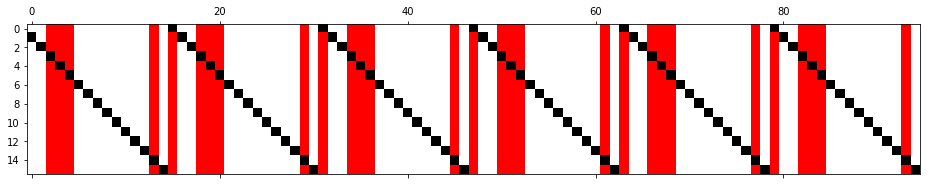

Score: 37.0:  36%|███▌      | 72/200 [04:46<08:46,  4.12s/ episodes]

Got new port for ns3gm interface:  9405


Score: 37.0:  36%|███▌      | 72/200 [04:50<08:46,  4.12s/ episodes]

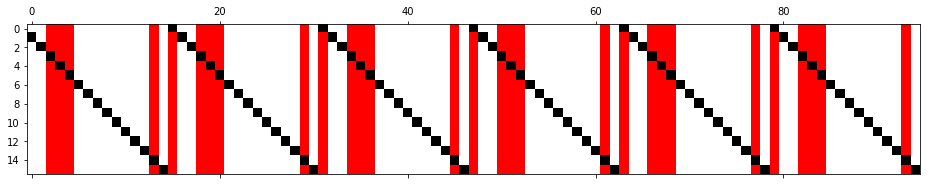

Score: 37.0:  36%|███▋      | 73/200 [04:50<08:44,  4.13s/ episodes]

Got new port for ns3gm interface:  7682


Score: 37.0:  36%|███▋      | 73/200 [04:54<08:44,  4.13s/ episodes]

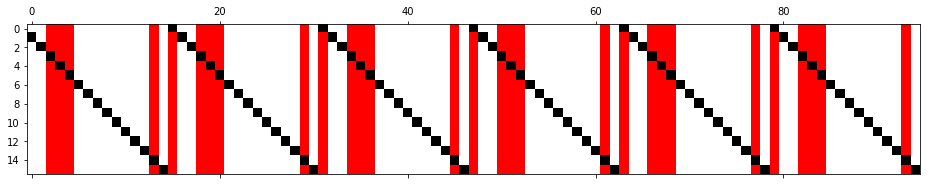

Score: 37.0:  37%|███▋      | 74/200 [04:54<08:39,  4.13s/ episodes]

Got new port for ns3gm interface:  9648


Score: 37.0:  37%|███▋      | 74/200 [04:58<08:39,  4.13s/ episodes]

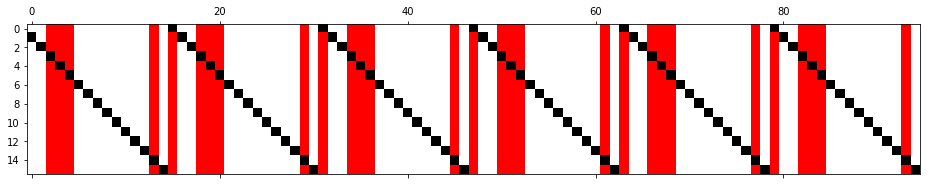

Score: 37.0:  38%|███▊      | 75/200 [04:58<08:34,  4.11s/ episodes]

Got new port for ns3gm interface:  5071


Score: 37.0:  38%|███▊      | 75/200 [05:02<08:34,  4.11s/ episodes]

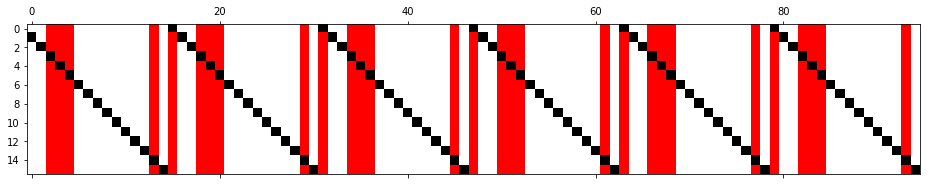

Score: 37.0:  38%|███▊      | 76/200 [05:02<08:31,  4.13s/ episodes]

Got new port for ns3gm interface:  7699


Score: 37.0:  38%|███▊      | 76/200 [05:06<08:31,  4.13s/ episodes]

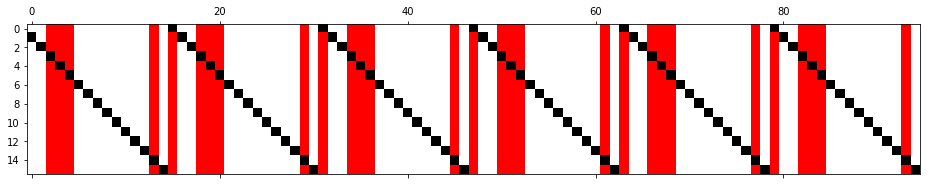

Score: 37.0:  38%|███▊      | 77/200 [05:06<08:25,  4.11s/ episodes]

Got new port for ns3gm interface:  9973


Score: 37.0:  38%|███▊      | 77/200 [05:10<08:25,  4.11s/ episodes]

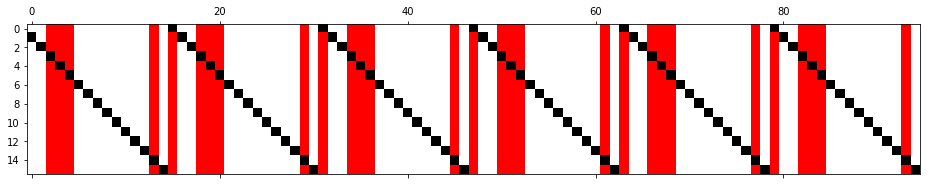

Score: 37.0:  39%|███▉      | 78/200 [05:10<08:21,  4.11s/ episodes]

Got new port for ns3gm interface:  9075


Score: 37.0:  39%|███▉      | 78/200 [05:14<08:21,  4.11s/ episodes]

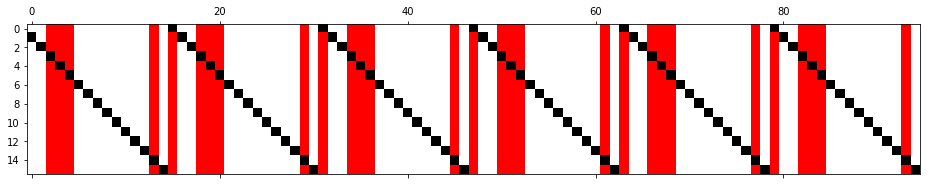

Score: 37.0:  40%|███▉      | 79/200 [05:14<08:15,  4.10s/ episodes]

Got new port for ns3gm interface:  6013


Score: 37.0:  40%|███▉      | 79/200 [05:18<08:15,  4.10s/ episodes]

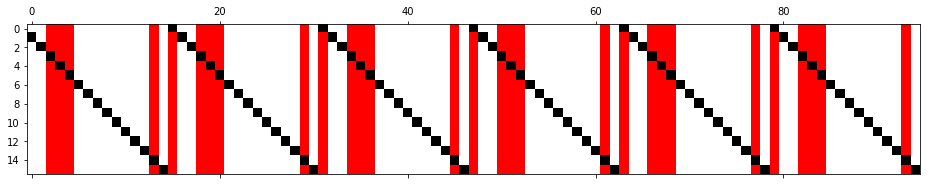

Score: 37.0:  40%|████      | 80/200 [05:18<08:11,  4.10s/ episodes]

Got new port for ns3gm interface:  6941


Score: 37.0:  40%|████      | 80/200 [05:22<08:11,  4.10s/ episodes]

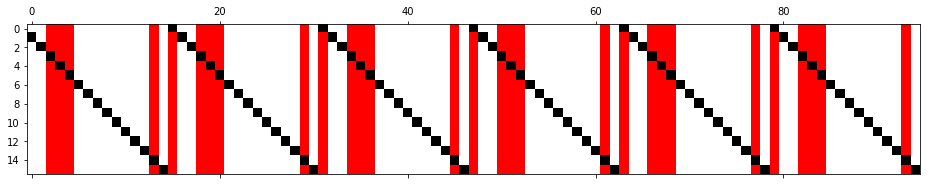

Score: 37.0:  40%|████      | 81/200 [05:22<08:07,  4.09s/ episodes]

Got new port for ns3gm interface:  8324


Score: 37.0:  40%|████      | 81/200 [05:26<08:07,  4.09s/ episodes]

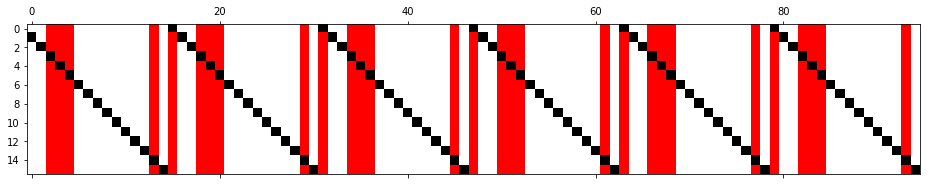

Score: 37.0:  41%|████      | 82/200 [05:27<08:03,  4.10s/ episodes]

Got new port for ns3gm interface:  7689


Score: 37.0:  41%|████      | 82/200 [05:31<08:03,  4.10s/ episodes]

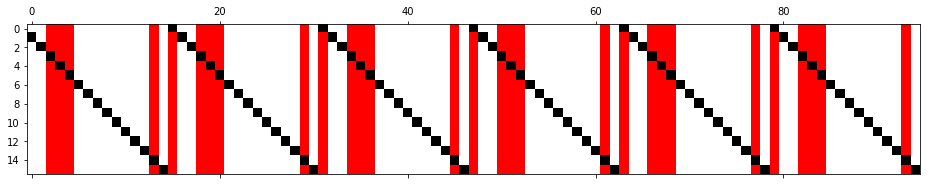

Score: 37.0:  42%|████▏     | 83/200 [05:31<07:58,  4.09s/ episodes]

Got new port for ns3gm interface:  6787


Score: 37.0:  42%|████▏     | 83/200 [05:35<07:58,  4.09s/ episodes]

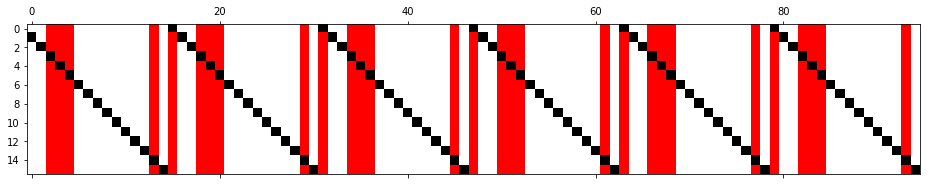

Score: 37.0:  42%|████▏     | 84/200 [05:35<07:53,  4.09s/ episodes]

Got new port for ns3gm interface:  8756


Score: 37.0:  42%|████▏     | 84/200 [05:39<07:53,  4.09s/ episodes]

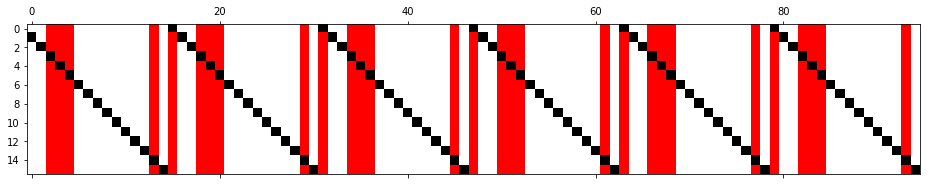

Score: 37.0:  42%|████▎     | 85/200 [05:39<07:51,  4.10s/ episodes]

Got new port for ns3gm interface:  5943


Score: 37.0:  42%|████▎     | 85/200 [05:43<07:51,  4.10s/ episodes]

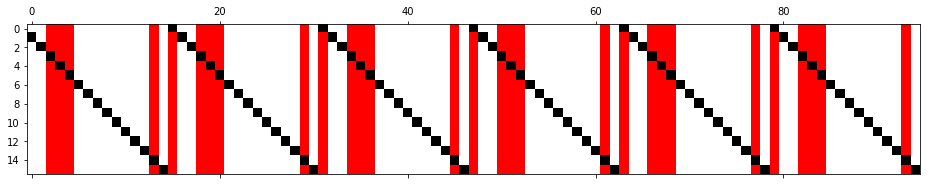

Score: 37.0:  43%|████▎     | 86/200 [05:43<07:48,  4.11s/ episodes]

Got new port for ns3gm interface:  8428


Score: 37.0:  43%|████▎     | 86/200 [05:47<07:48,  4.11s/ episodes]

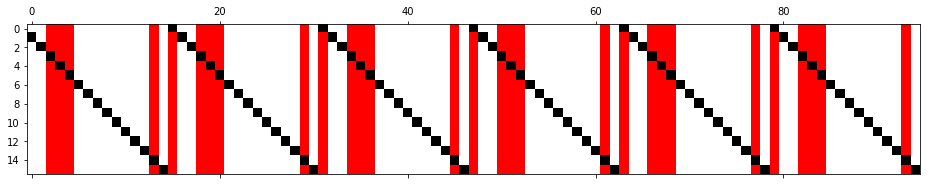

Score: 37.0:  44%|████▎     | 87/200 [05:47<07:44,  4.11s/ episodes]

Got new port for ns3gm interface:  8514


Score: 37.0:  44%|████▎     | 87/200 [05:51<07:44,  4.11s/ episodes]

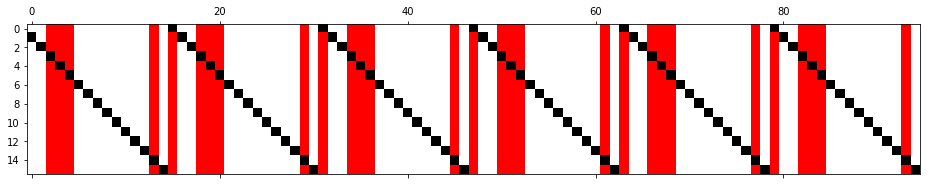

Score: 37.0:  44%|████▍     | 88/200 [05:51<07:39,  4.10s/ episodes]

Got new port for ns3gm interface:  5473


Score: 37.0:  44%|████▍     | 88/200 [05:55<07:39,  4.10s/ episodes]

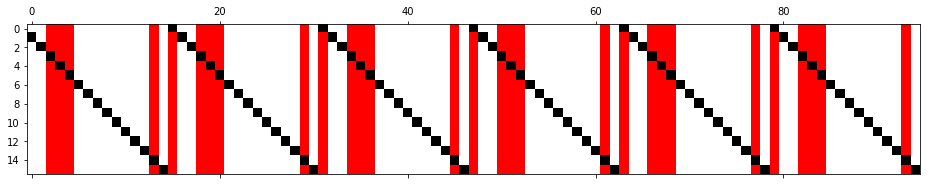

Score: 37.0:  44%|████▍     | 89/200 [05:55<07:34,  4.09s/ episodes]

Got new port for ns3gm interface:  8228


Score: 37.0:  44%|████▍     | 89/200 [05:59<07:34,  4.09s/ episodes]

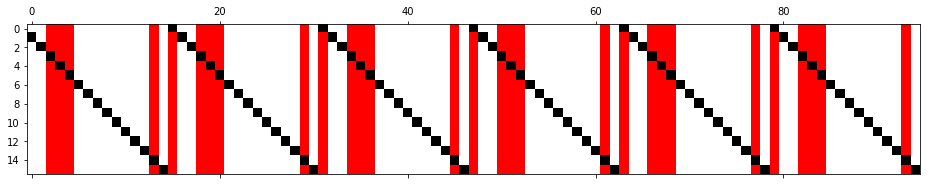

Score: 37.0:  45%|████▌     | 90/200 [05:59<07:32,  4.11s/ episodes]

Got new port for ns3gm interface:  5916


Score: 37.0:  45%|████▌     | 90/200 [06:03<07:32,  4.11s/ episodes]

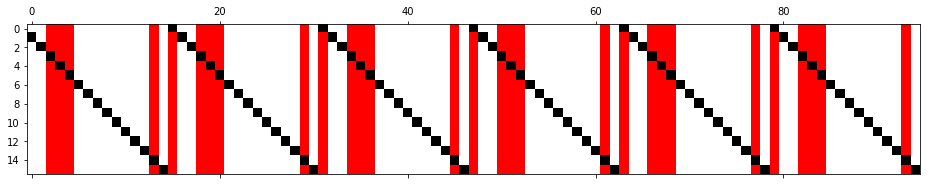

Score: 37.0:  46%|████▌     | 91/200 [06:03<07:27,  4.10s/ episodes]

Got new port for ns3gm interface:  5375


Score: 37.0:  46%|████▌     | 91/200 [06:07<07:27,  4.10s/ episodes]

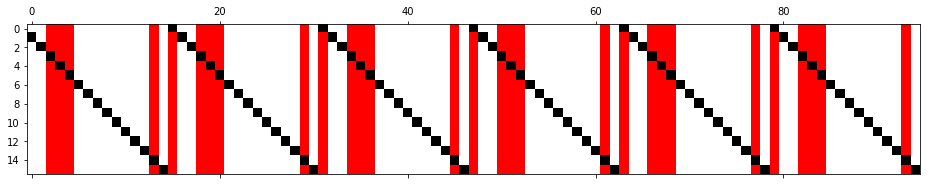

Score: 37.0:  46%|████▌     | 92/200 [06:08<07:25,  4.12s/ episodes]

Got new port for ns3gm interface:  5443


Score: 37.0:  46%|████▌     | 92/200 [06:12<07:25,  4.12s/ episodes]

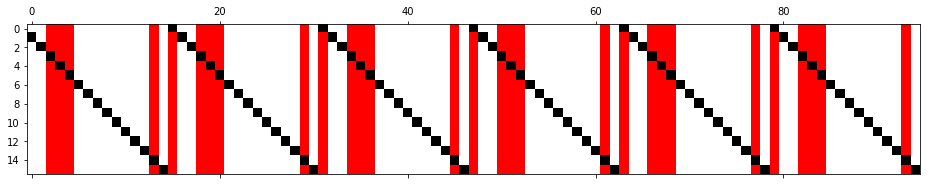

Score: 37.0:  46%|████▋     | 93/200 [06:12<07:20,  4.11s/ episodes]

Got new port for ns3gm interface:  5335


Score: 37.0:  46%|████▋     | 93/200 [06:16<07:20,  4.11s/ episodes]

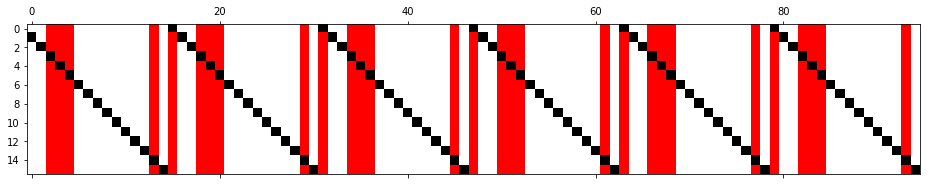

Score: 37.0:  47%|████▋     | 94/200 [06:16<07:14,  4.10s/ episodes]

Got new port for ns3gm interface:  8097


Score: 37.0:  47%|████▋     | 94/200 [06:20<07:14,  4.10s/ episodes]

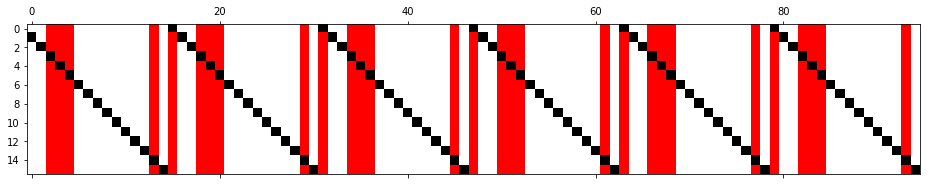

Score: 37.0:  48%|████▊     | 95/200 [06:20<07:12,  4.12s/ episodes]

Got new port for ns3gm interface:  9237


Score: 37.0:  48%|████▊     | 95/200 [06:24<07:12,  4.12s/ episodes]

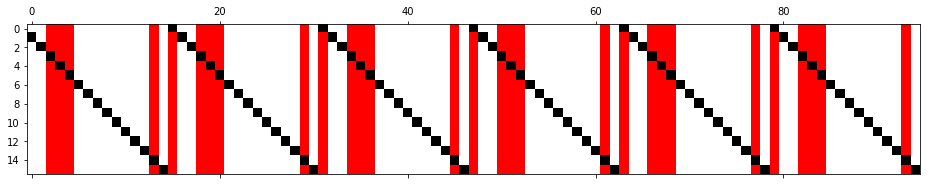

Score: 37.0:  48%|████▊     | 96/200 [06:24<07:07,  4.11s/ episodes]

Got new port for ns3gm interface:  8248


Score: 37.0:  48%|████▊     | 96/200 [06:28<07:07,  4.11s/ episodes]

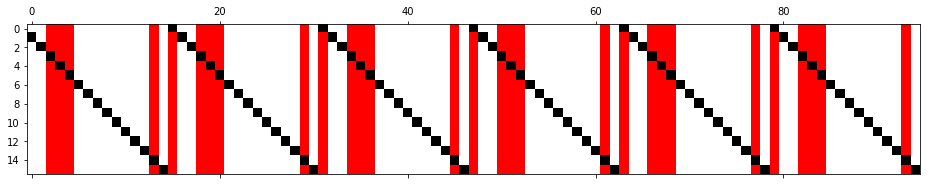

Score: 37.0:  48%|████▊     | 97/200 [06:28<07:02,  4.11s/ episodes]

Got new port for ns3gm interface:  5136


Score: 37.0:  48%|████▊     | 97/200 [06:32<07:02,  4.11s/ episodes]

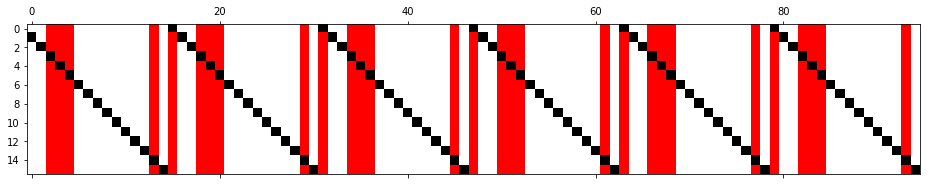

Score: 37.0:  49%|████▉     | 98/200 [06:32<06:58,  4.10s/ episodes]

Got new port for ns3gm interface:  5887


Score: 37.0:  49%|████▉     | 98/200 [06:36<06:58,  4.10s/ episodes]

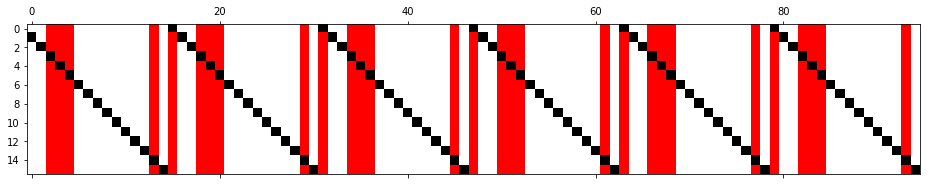

Score: 37.0:  50%|████▉     | 99/200 [06:36<06:54,  4.10s/ episodes]

Got new port for ns3gm interface:  5381


Score: 37.0:  50%|████▉     | 99/200 [06:40<06:54,  4.10s/ episodes]

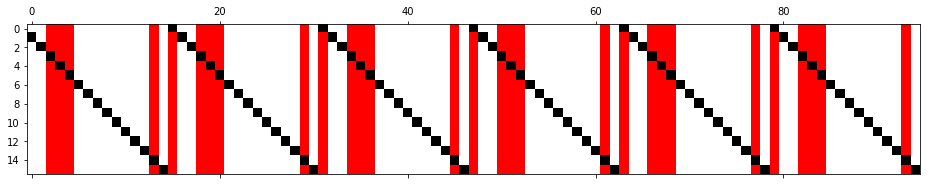

Score: 37.0:  50%|█████     | 100/200 [06:40<06:50,  4.11s/ episodes]

Got new port for ns3gm interface:  6144


Score: 37.0:  50%|█████     | 100/200 [06:45<06:50,  4.11s/ episodes]

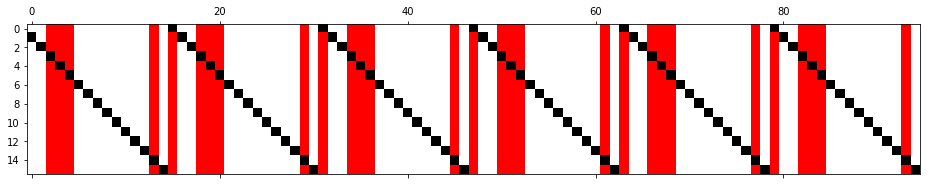

Score: 37.0:  50%|█████     | 101/200 [06:45<06:46,  4.11s/ episodes]

Got new port for ns3gm interface:  8544


Score: 37.0:  50%|█████     | 101/200 [06:49<06:46,  4.11s/ episodes]

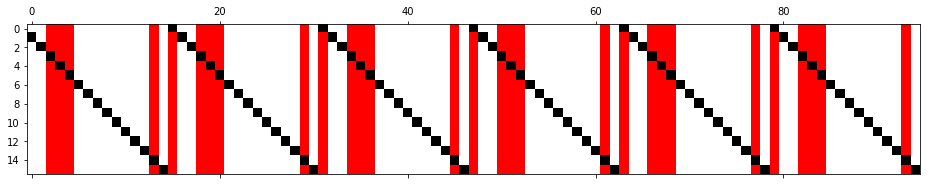

Score: 37.0:  51%|█████     | 102/200 [06:49<06:43,  4.12s/ episodes]

Got new port for ns3gm interface:  9926


Score: 37.0:  51%|█████     | 102/200 [06:53<06:43,  4.12s/ episodes]

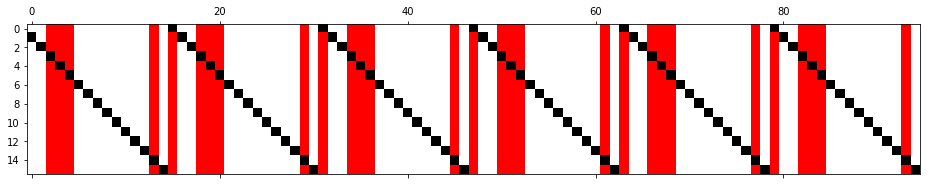

Score: 37.0:  52%|█████▏    | 103/200 [06:53<06:40,  4.13s/ episodes]

Got new port for ns3gm interface:  9946


Score: 37.0:  52%|█████▏    | 103/200 [06:57<06:40,  4.13s/ episodes]

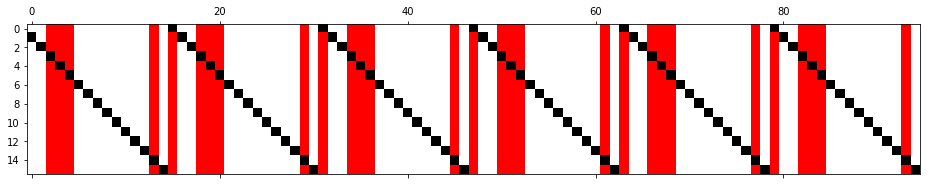

Score: 37.0:  52%|█████▏    | 104/200 [06:57<06:35,  4.12s/ episodes]

Got new port for ns3gm interface:  5489


Score: 37.0:  52%|█████▏    | 104/200 [07:01<06:35,  4.12s/ episodes]

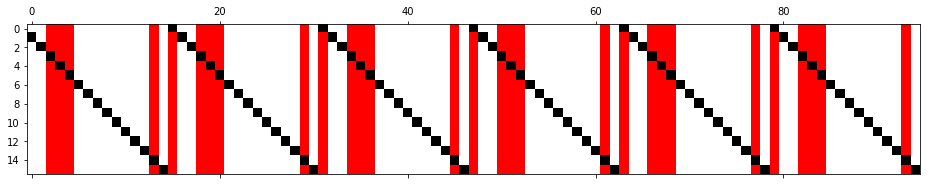

Score: 37.0:  52%|█████▎    | 105/200 [07:01<06:31,  4.12s/ episodes]

Got new port for ns3gm interface:  9396


Score: 37.0:  52%|█████▎    | 105/200 [07:05<06:31,  4.12s/ episodes]

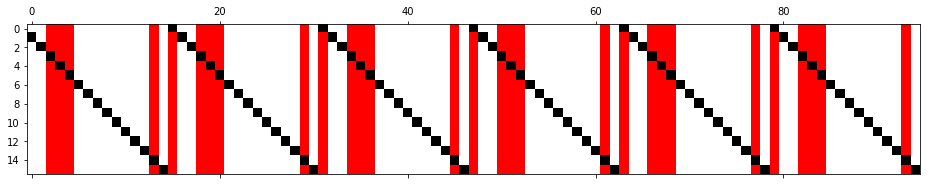

Score: 37.0:  53%|█████▎    | 106/200 [07:05<06:25,  4.11s/ episodes]

Got new port for ns3gm interface:  9188


Score: 37.0:  53%|█████▎    | 106/200 [07:09<06:25,  4.11s/ episodes]

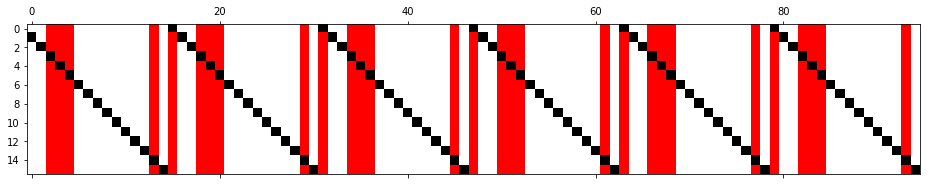

Score: 37.0:  54%|█████▎    | 107/200 [07:09<06:21,  4.10s/ episodes]

Got new port for ns3gm interface:  6195


Score: 37.0:  54%|█████▎    | 107/200 [07:13<06:21,  4.10s/ episodes]

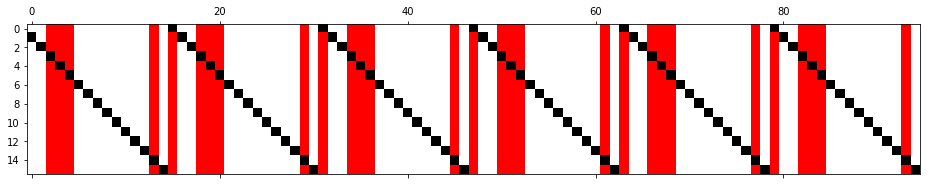

Score: 37.0:  54%|█████▍    | 108/200 [07:13<06:18,  4.11s/ episodes]

Got new port for ns3gm interface:  9473


Score: 37.0:  54%|█████▍    | 108/200 [07:17<06:18,  4.11s/ episodes]

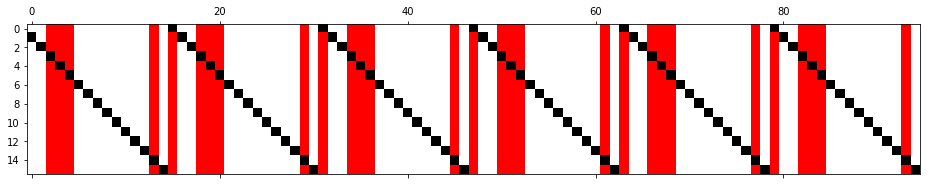

Score: 37.0:  55%|█████▍    | 109/200 [07:18<06:13,  4.11s/ episodes]

Got new port for ns3gm interface:  9236


Score: 37.0:  55%|█████▍    | 109/200 [07:21<06:13,  4.11s/ episodes]

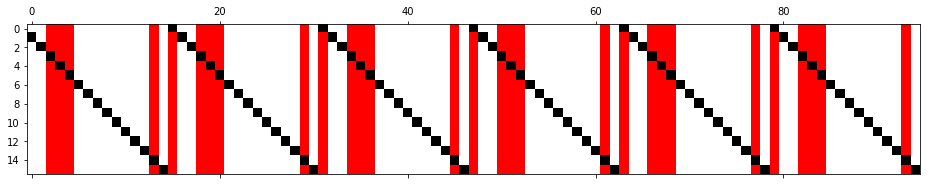

Score: 37.0:  55%|█████▌    | 110/200 [07:22<06:08,  4.10s/ episodes]

Got new port for ns3gm interface:  9336


Score: 37.0:  55%|█████▌    | 110/200 [07:26<06:08,  4.10s/ episodes]

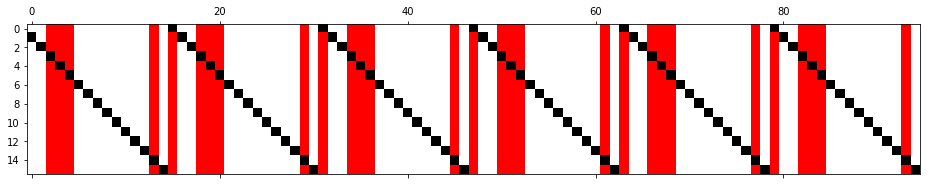

Score: 37.0:  56%|█████▌    | 111/200 [07:26<06:03,  4.09s/ episodes]

Got new port for ns3gm interface:  6976


Score: 37.0:  56%|█████▌    | 111/200 [07:30<06:03,  4.09s/ episodes]

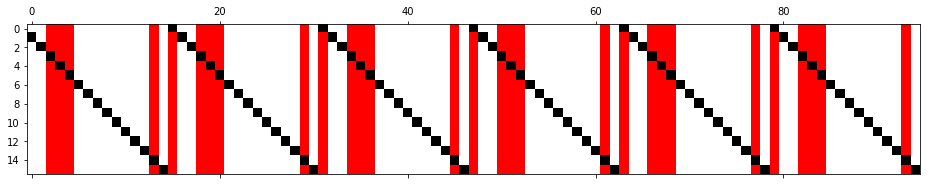

Score: 37.0:  56%|█████▌    | 112/200 [07:30<05:59,  4.08s/ episodes]

Got new port for ns3gm interface:  7436


Score: 37.0:  56%|█████▌    | 112/200 [07:34<05:59,  4.08s/ episodes]

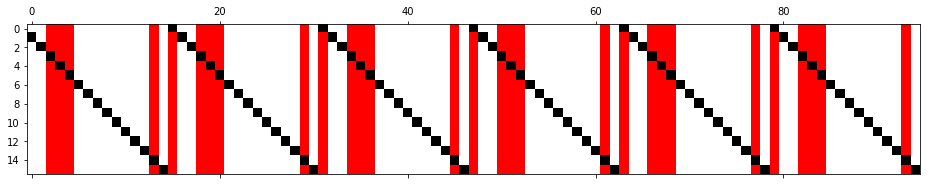

Score: 37.0:  56%|█████▋    | 113/200 [07:34<05:56,  4.10s/ episodes]

Got new port for ns3gm interface:  7103


Score: 37.0:  56%|█████▋    | 113/200 [07:38<05:56,  4.10s/ episodes]

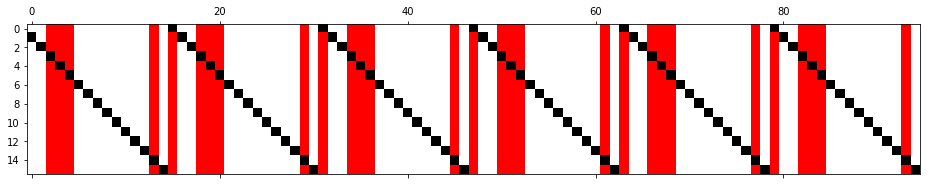

Score: 37.0:  57%|█████▋    | 114/200 [07:38<05:54,  4.12s/ episodes]

Got new port for ns3gm interface:  7688


Score: 37.0:  57%|█████▋    | 114/200 [07:42<05:54,  4.12s/ episodes]

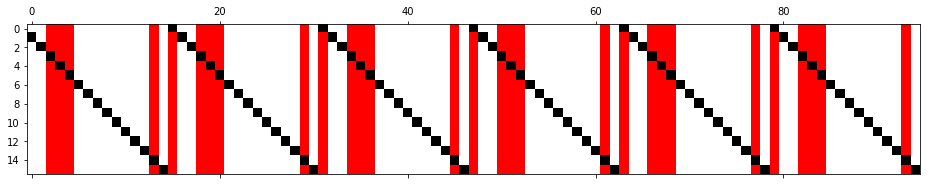

Score: 37.0:  57%|█████▊    | 115/200 [07:42<05:49,  4.11s/ episodes]

Got new port for ns3gm interface:  7287


Score: 37.0:  57%|█████▊    | 115/200 [07:46<05:49,  4.11s/ episodes]

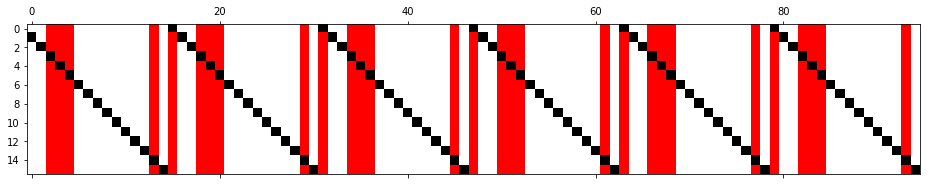

Score: 37.0:  58%|█████▊    | 116/200 [07:46<05:45,  4.11s/ episodes]

Got new port for ns3gm interface:  8953


Score: 37.0:  58%|█████▊    | 116/200 [07:50<05:45,  4.11s/ episodes]

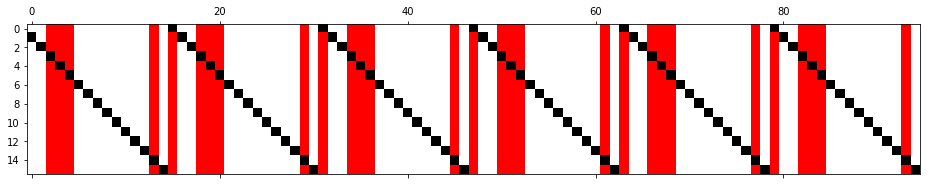

Score: 37.0:  58%|█████▊    | 117/200 [07:50<05:43,  4.14s/ episodes]

Got new port for ns3gm interface:  8476


Score: 37.0:  58%|█████▊    | 117/200 [07:54<05:43,  4.14s/ episodes]

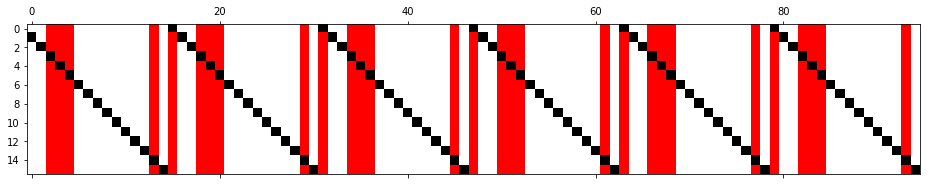

Score: 37.0:  59%|█████▉    | 118/200 [07:54<05:36,  4.10s/ episodes]

Got new port for ns3gm interface:  8619


Score: 37.0:  59%|█████▉    | 118/200 [07:58<05:36,  4.10s/ episodes]

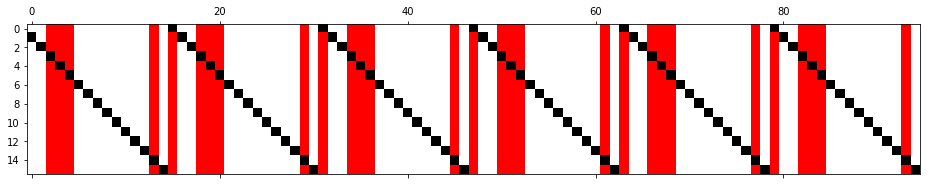

Score: 37.0:  60%|█████▉    | 119/200 [07:58<05:28,  4.05s/ episodes]

Got new port for ns3gm interface:  6369


Score: 37.0:  60%|█████▉    | 119/200 [08:02<05:28,  4.05s/ episodes]

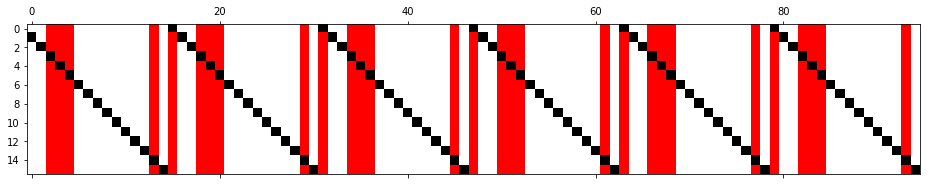

Score: 37.0:  60%|██████    | 120/200 [08:02<05:22,  4.03s/ episodes]

Got new port for ns3gm interface:  8743


Score: 37.0:  60%|██████    | 120/200 [08:06<05:22,  4.03s/ episodes]

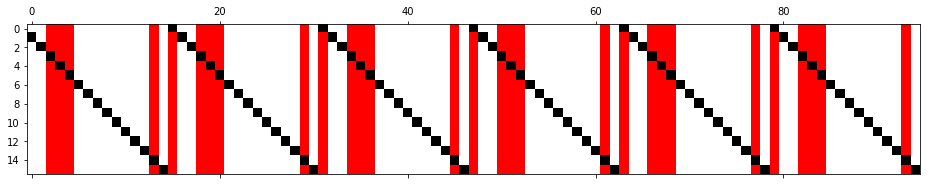

Score: 37.0:  60%|██████    | 121/200 [08:06<05:17,  4.02s/ episodes]

Got new port for ns3gm interface:  6367


Score: 37.0:  60%|██████    | 121/200 [08:10<05:17,  4.02s/ episodes]

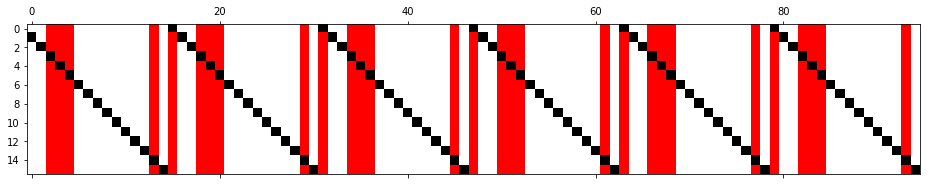

Score: 37.0:  61%|██████    | 122/200 [08:10<05:12,  4.01s/ episodes]

Got new port for ns3gm interface:  6031


Score: 37.0:  61%|██████    | 122/200 [08:14<05:12,  4.01s/ episodes]

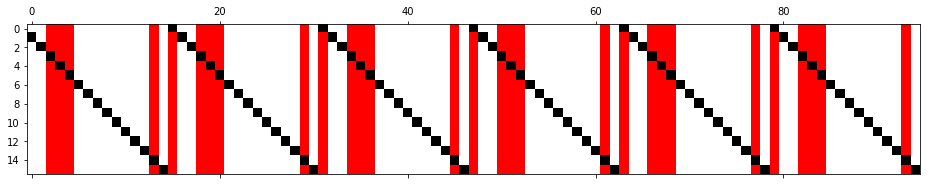

Score: 37.0:  62%|██████▏   | 123/200 [08:14<05:08,  4.01s/ episodes]

Got new port for ns3gm interface:  9380


Score: 37.0:  62%|██████▏   | 123/200 [08:18<05:08,  4.01s/ episodes]

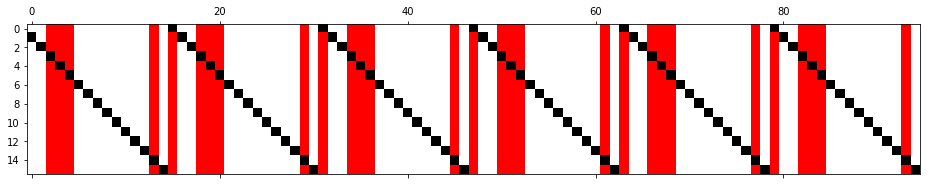

Score: 37.0:  62%|██████▏   | 124/200 [08:18<05:02,  3.98s/ episodes]

Got new port for ns3gm interface:  7193


Score: 37.0:  62%|██████▏   | 124/200 [08:22<05:02,  3.98s/ episodes]

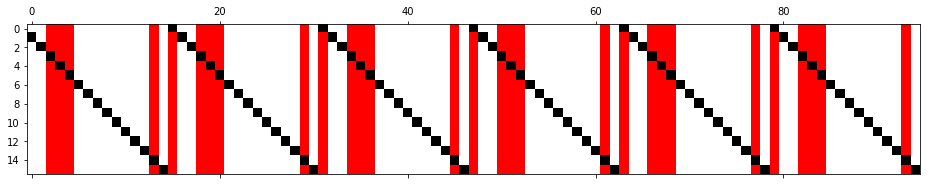

Score: 37.0:  62%|██████▎   | 125/200 [08:22<04:57,  3.97s/ episodes]

Got new port for ns3gm interface:  7090


Score: 37.0:  62%|██████▎   | 125/200 [08:26<04:57,  3.97s/ episodes]

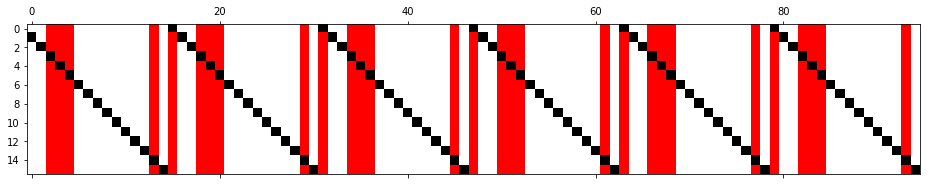

Score: 37.0:  63%|██████▎   | 126/200 [08:26<04:51,  3.94s/ episodes]

Got new port for ns3gm interface:  6248


Score: 37.0:  63%|██████▎   | 126/200 [08:30<04:51,  3.94s/ episodes]

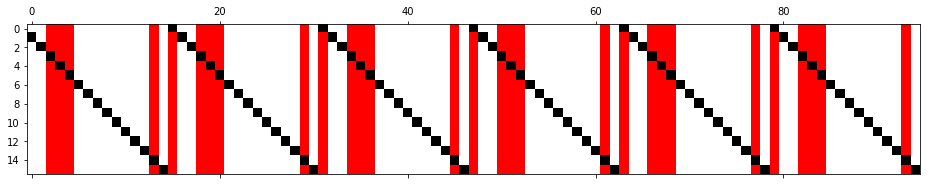

Score: 37.0:  64%|██████▎   | 127/200 [08:30<04:46,  3.93s/ episodes]

Got new port for ns3gm interface:  5914


Score: 37.0:  64%|██████▎   | 127/200 [08:34<04:46,  3.93s/ episodes]

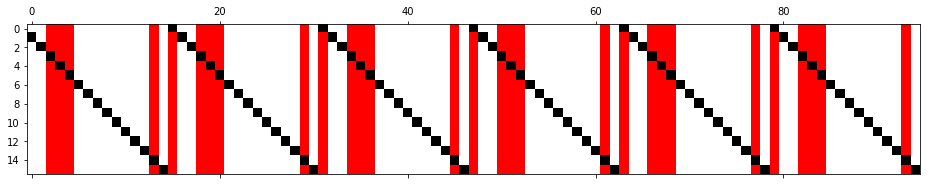

Score: 37.0:  64%|██████▍   | 128/200 [08:34<04:44,  3.96s/ episodes]

Got new port for ns3gm interface:  9332


Score: 37.0:  64%|██████▍   | 128/200 [08:38<04:44,  3.96s/ episodes]

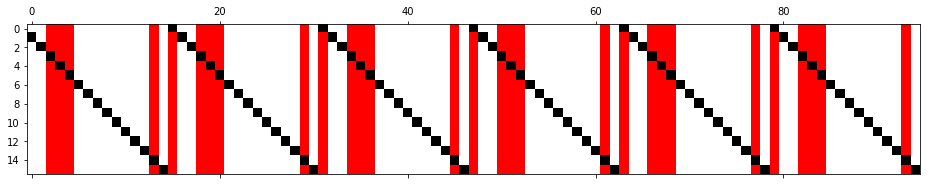

Score: 37.0:  64%|██████▍   | 129/200 [08:38<04:41,  3.96s/ episodes]

Got new port for ns3gm interface:  9659


Score: 37.0:  64%|██████▍   | 129/200 [08:42<04:41,  3.96s/ episodes]

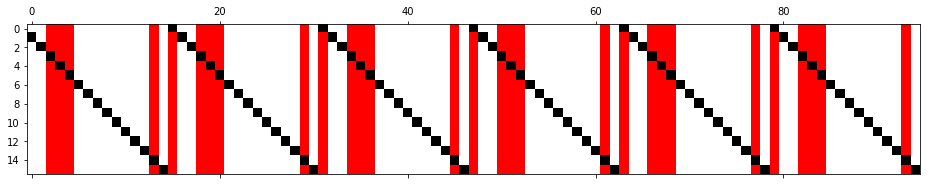

Score: 37.0:  65%|██████▌   | 130/200 [08:42<04:39,  3.99s/ episodes]

Got new port for ns3gm interface:  6664


Score: 37.0:  65%|██████▌   | 130/200 [08:46<04:39,  3.99s/ episodes]

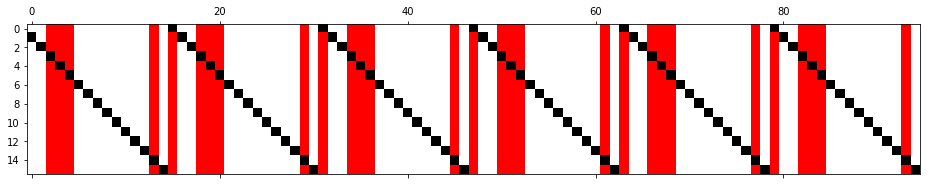

Score: 37.0:  66%|██████▌   | 131/200 [08:46<04:34,  3.98s/ episodes]

Got new port for ns3gm interface:  5980


Score: 37.0:  66%|██████▌   | 131/200 [08:50<04:34,  3.98s/ episodes]

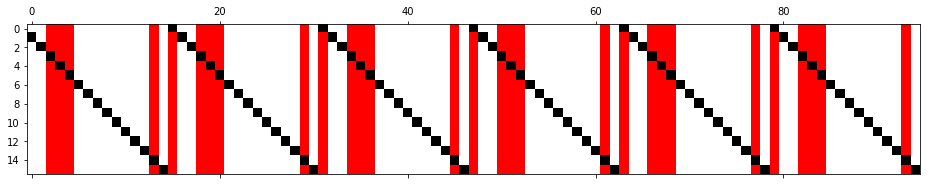

Score: 37.0:  66%|██████▌   | 132/200 [08:50<04:30,  3.97s/ episodes]

Got new port for ns3gm interface:  7205


Score: 37.0:  66%|██████▌   | 132/200 [08:54<04:30,  3.97s/ episodes]

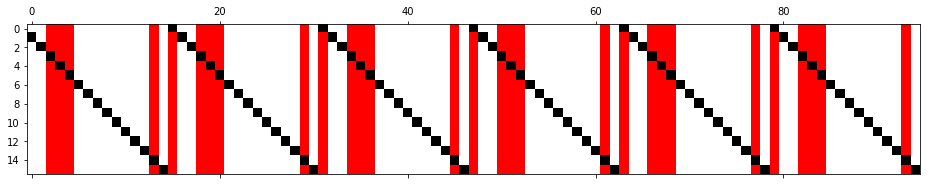

Score: 37.0:  66%|██████▋   | 133/200 [08:54<04:28,  4.01s/ episodes]

Got new port for ns3gm interface:  9500


Score: 37.0:  66%|██████▋   | 133/200 [08:58<04:28,  4.01s/ episodes]

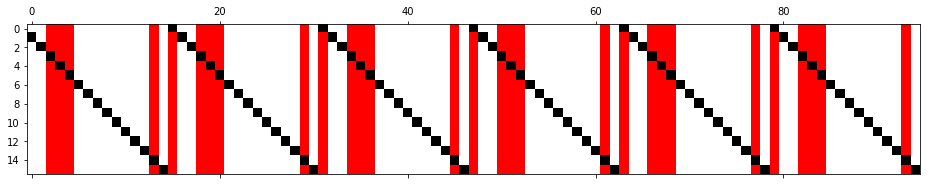

Score: 37.0:  67%|██████▋   | 134/200 [08:58<04:24,  4.01s/ episodes]

Got new port for ns3gm interface:  5316


Score: 37.0:  67%|██████▋   | 134/200 [09:02<04:24,  4.01s/ episodes]

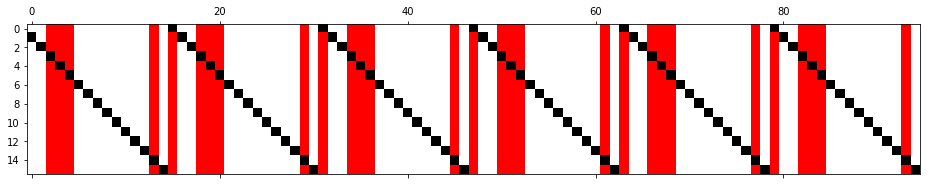

Score: 37.0:  68%|██████▊   | 135/200 [09:02<04:19,  3.99s/ episodes]

Got new port for ns3gm interface:  8780


Score: 37.0:  68%|██████▊   | 135/200 [09:06<04:19,  3.99s/ episodes]

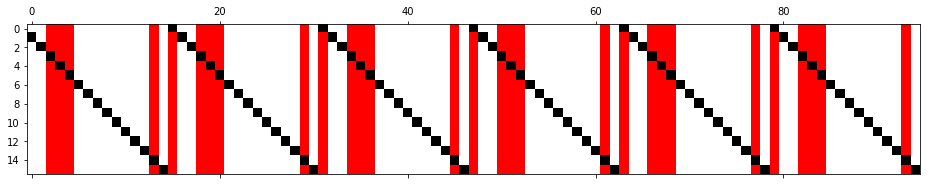

Score: 37.0:  68%|██████▊   | 136/200 [09:06<04:15,  3.99s/ episodes]

Got new port for ns3gm interface:  8915


Score: 37.0:  68%|██████▊   | 136/200 [09:10<04:15,  3.99s/ episodes]

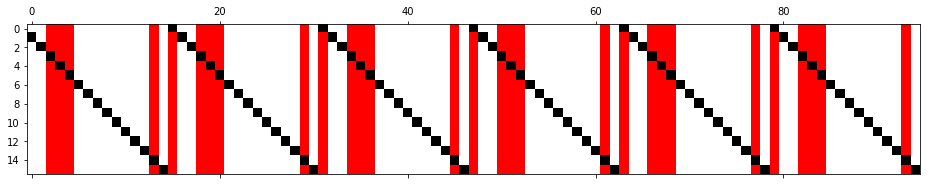

Score: 37.0:  68%|██████▊   | 137/200 [09:10<04:12,  4.00s/ episodes]

Got new port for ns3gm interface:  6354


Score: 37.0:  68%|██████▊   | 137/200 [09:14<04:12,  4.00s/ episodes]

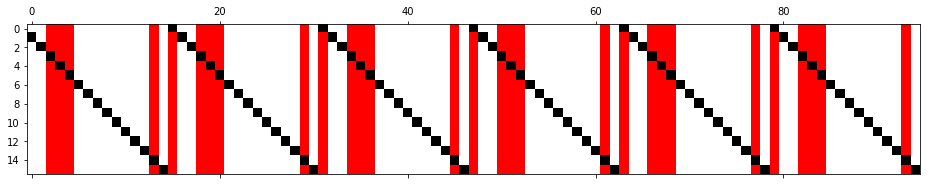

Score: 37.0:  69%|██████▉   | 138/200 [09:14<04:11,  4.06s/ episodes]

Got new port for ns3gm interface:  8731


Score: 37.0:  69%|██████▉   | 138/200 [09:18<04:11,  4.06s/ episodes]

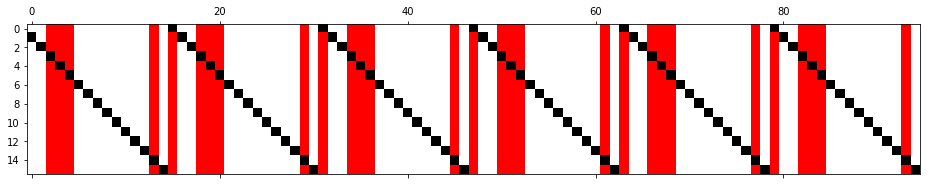

Score: 37.0:  70%|██████▉   | 139/200 [09:18<04:11,  4.13s/ episodes]

Got new port for ns3gm interface:  8843


Score: 37.0:  70%|██████▉   | 139/200 [09:22<04:11,  4.13s/ episodes]

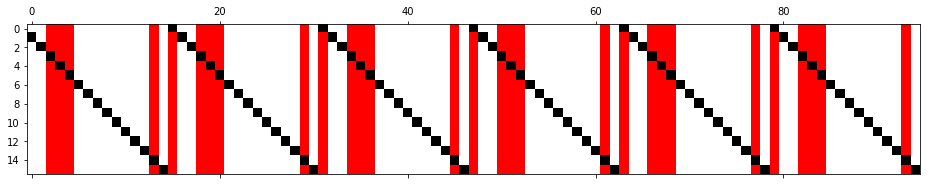

Score: 37.0:  70%|███████   | 140/200 [09:22<04:02,  4.05s/ episodes]

Got new port for ns3gm interface:  8817


Score: 37.0:  70%|███████   | 140/200 [09:26<04:02,  4.05s/ episodes]

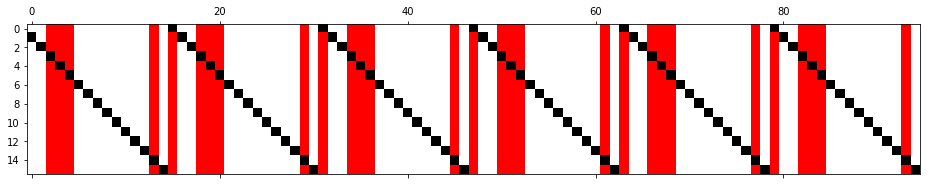

Score: 37.0:  70%|███████   | 141/200 [09:26<03:56,  4.00s/ episodes]

Got new port for ns3gm interface:  8636


Score: 37.0:  70%|███████   | 141/200 [09:30<03:56,  4.00s/ episodes]

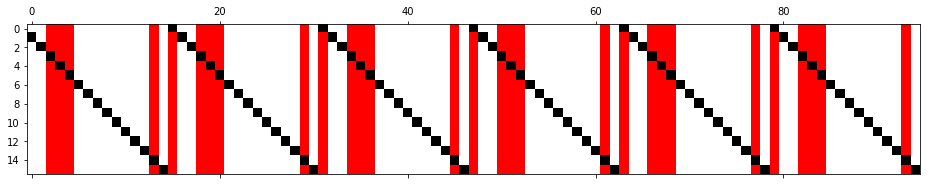

Score: 37.0:  71%|███████   | 142/200 [09:30<03:50,  3.98s/ episodes]

Got new port for ns3gm interface:  9814


Score: 37.0:  71%|███████   | 142/200 [09:34<03:50,  3.98s/ episodes]

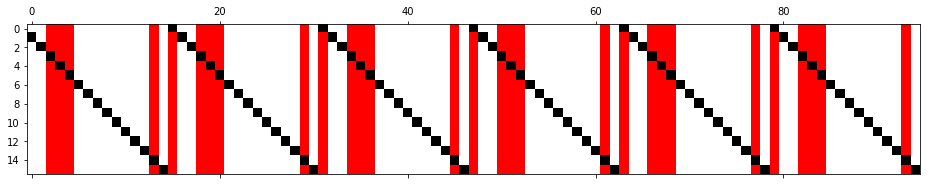

Score: 37.0:  72%|███████▏  | 143/200 [09:34<03:45,  3.95s/ episodes]

Got new port for ns3gm interface:  6946


Score: 37.0:  72%|███████▏  | 143/200 [09:38<03:45,  3.95s/ episodes]

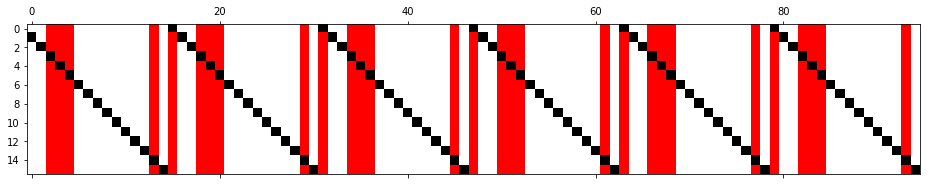

Score: 37.0:  72%|███████▏  | 144/200 [09:39<03:51,  4.13s/ episodes]

Got new port for ns3gm interface:  8928


Score: 37.0:  72%|███████▏  | 144/200 [09:42<03:51,  4.13s/ episodes]

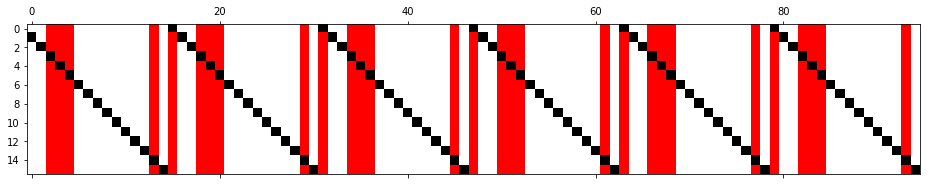

Score: 37.0:  72%|███████▎  | 145/200 [09:43<03:43,  4.07s/ episodes]

Got new port for ns3gm interface:  5197


Score: 37.0:  72%|███████▎  | 145/200 [09:46<03:43,  4.07s/ episodes]

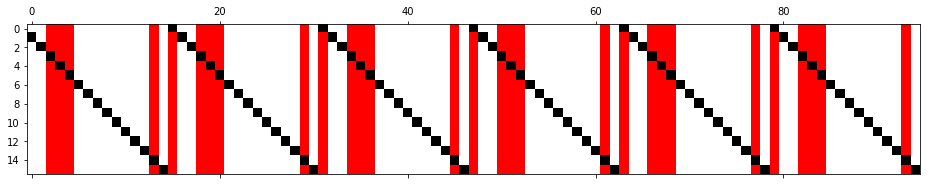

Score: 37.0:  73%|███████▎  | 146/200 [09:46<03:37,  4.02s/ episodes]

Got new port for ns3gm interface:  9618


Score: 37.0:  73%|███████▎  | 146/200 [09:50<03:37,  4.02s/ episodes]

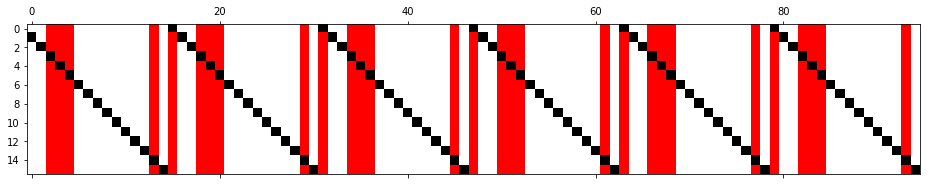

Score: 37.0:  74%|███████▎  | 147/200 [09:50<03:31,  3.99s/ episodes]

Got new port for ns3gm interface:  8555


Score: 37.0:  74%|███████▎  | 147/200 [09:54<03:31,  3.99s/ episodes]

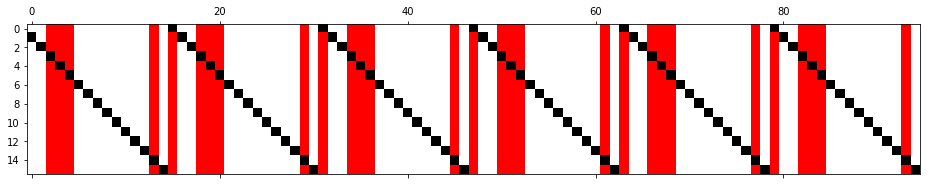

Score: 37.0:  74%|███████▍  | 148/200 [09:54<03:26,  3.96s/ episodes]

Got new port for ns3gm interface:  7110


Score: 37.0:  74%|███████▍  | 148/200 [09:58<03:26,  3.96s/ episodes]

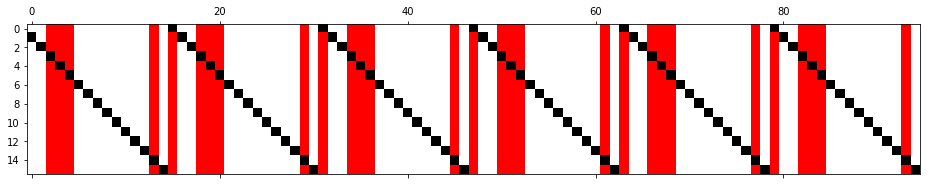

Score: 37.0:  74%|███████▍  | 149/200 [09:58<03:20,  3.94s/ episodes]

Got new port for ns3gm interface:  7576


Score: 37.0:  74%|███████▍  | 149/200 [10:02<03:20,  3.94s/ episodes]

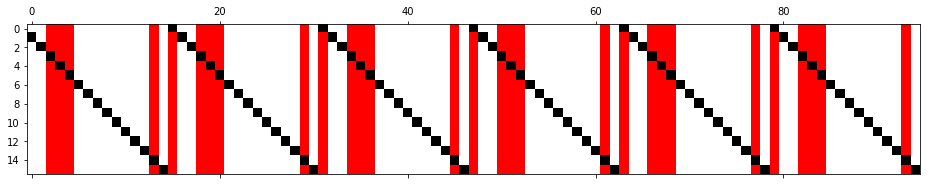

Score: 37.0:  75%|███████▌  | 150/200 [10:02<03:15,  3.92s/ episodes]

Got new port for ns3gm interface:  6985


Score: 37.0:  75%|███████▌  | 150/200 [10:06<03:15,  3.92s/ episodes]

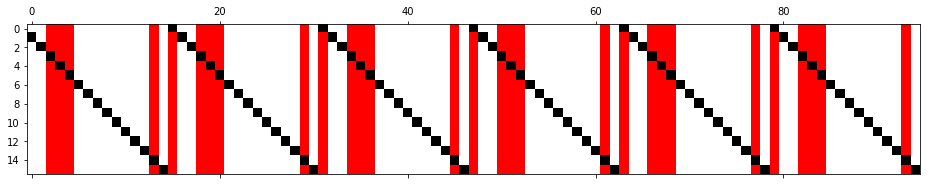

Score: 37.0:  76%|███████▌  | 151/200 [10:06<03:11,  3.91s/ episodes]

Got new port for ns3gm interface:  7300


Score: 37.0:  76%|███████▌  | 151/200 [10:10<03:11,  3.91s/ episodes]

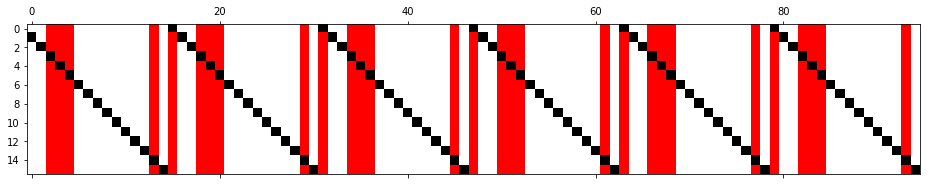

Score: 37.0:  76%|███████▌  | 152/200 [10:10<03:07,  3.91s/ episodes]

Got new port for ns3gm interface:  8563


Score: 37.0:  76%|███████▌  | 152/200 [10:14<03:07,  3.91s/ episodes]

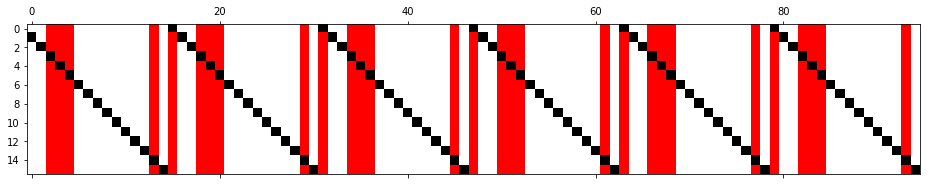

Score: 37.0:  76%|███████▋  | 153/200 [10:14<03:13,  4.12s/ episodes]

Got new port for ns3gm interface:  6617


Score: 37.0:  76%|███████▋  | 153/200 [10:18<03:13,  4.12s/ episodes]

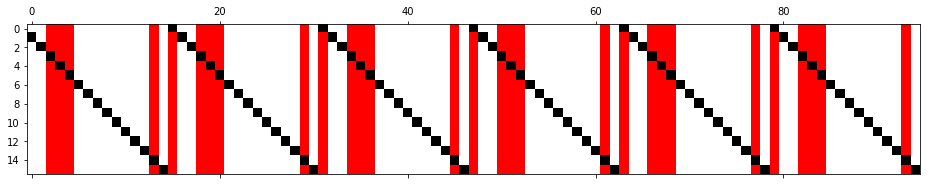

Score: 37.0:  77%|███████▋  | 154/200 [10:18<03:06,  4.05s/ episodes]

Got new port for ns3gm interface:  6466


Score: 37.0:  77%|███████▋  | 154/200 [10:22<03:06,  4.05s/ episodes]

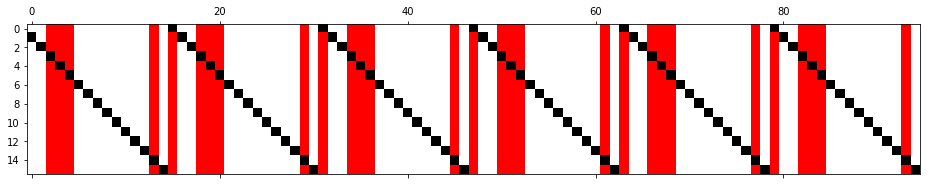

Score: 37.0:  78%|███████▊  | 155/200 [10:22<02:59,  4.00s/ episodes]

Got new port for ns3gm interface:  7812


Score: 37.0:  78%|███████▊  | 155/200 [10:26<02:59,  4.00s/ episodes]

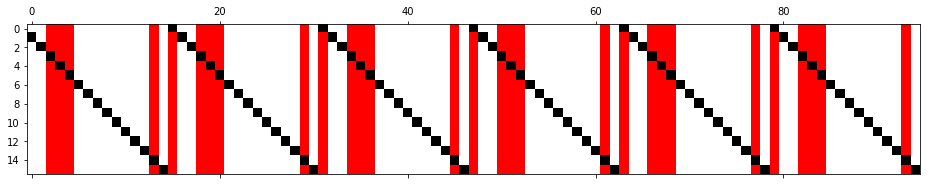

Score: 37.0:  78%|███████▊  | 156/200 [10:26<02:54,  3.96s/ episodes]

Got new port for ns3gm interface:  6122


Score: 37.0:  78%|███████▊  | 156/200 [10:30<02:54,  3.96s/ episodes]

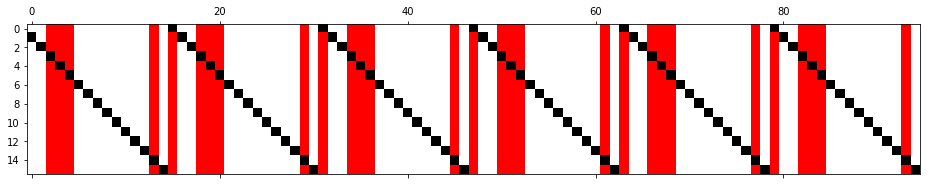

Score: 37.0:  78%|███████▊  | 157/200 [10:30<02:49,  3.94s/ episodes]

Got new port for ns3gm interface:  8211


Score: 37.0:  78%|███████▊  | 157/200 [10:34<02:49,  3.94s/ episodes]

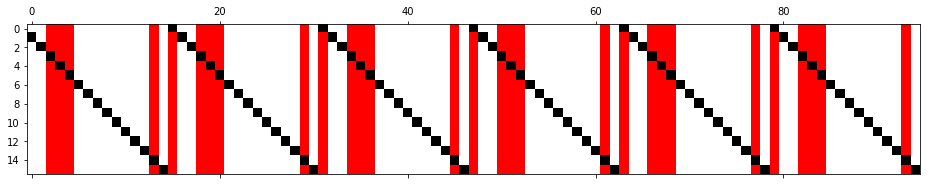

Score: 37.0:  79%|███████▉  | 158/200 [10:34<02:46,  3.95s/ episodes]

Got new port for ns3gm interface:  5109


Score: 37.0:  79%|███████▉  | 158/200 [10:38<02:46,  3.95s/ episodes]

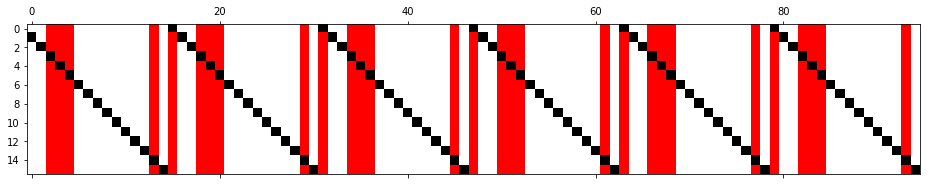

Score: 37.0:  80%|███████▉  | 159/200 [10:38<02:42,  3.96s/ episodes]

Got new port for ns3gm interface:  5760


Score: 37.0:  80%|███████▉  | 159/200 [10:42<02:42,  3.96s/ episodes]

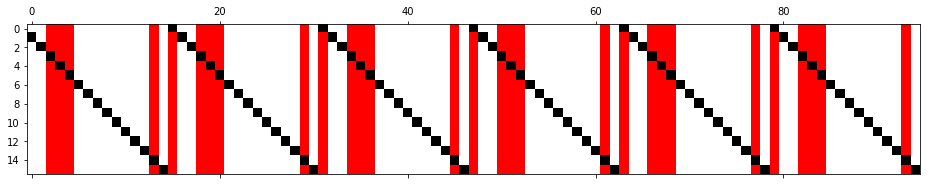

Score: 37.0:  80%|████████  | 160/200 [10:42<02:37,  3.94s/ episodes]

Got new port for ns3gm interface:  8854


Score: 37.0:  80%|████████  | 160/200 [10:46<02:37,  3.94s/ episodes]

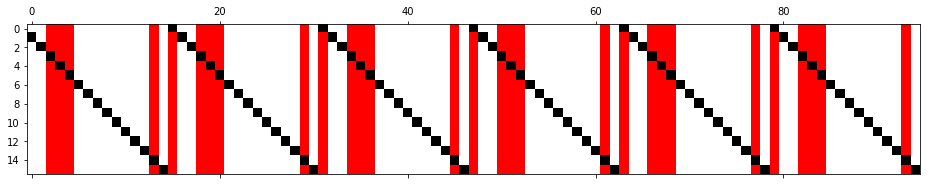

Score: 37.0:  80%|████████  | 161/200 [10:46<02:33,  3.93s/ episodes]

Got new port for ns3gm interface:  6179


Score: 37.0:  80%|████████  | 161/200 [10:49<02:33,  3.93s/ episodes]

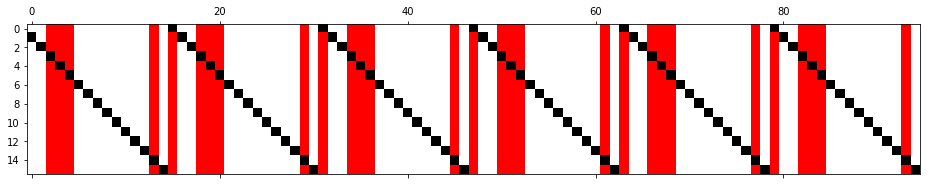

Score: 37.0:  81%|████████  | 162/200 [10:50<02:28,  3.91s/ episodes]

Got new port for ns3gm interface:  6384


Score: 37.0:  81%|████████  | 162/200 [10:53<02:28,  3.91s/ episodes]

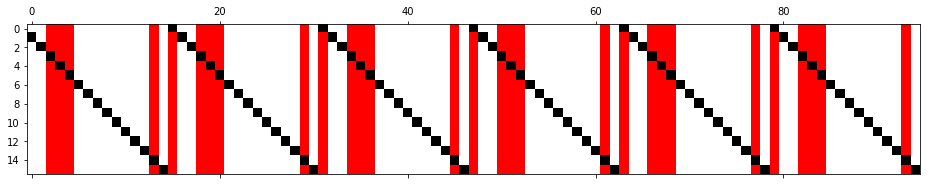

Score: 37.0:  82%|████████▏ | 163/200 [10:53<02:24,  3.91s/ episodes]

Got new port for ns3gm interface:  5372


Score: 37.0:  82%|████████▏ | 163/200 [10:57<02:24,  3.91s/ episodes]

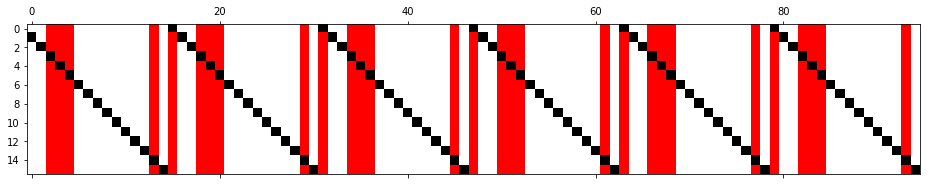

Score: 37.0:  82%|████████▏ | 164/200 [10:57<02:20,  3.90s/ episodes]

Got new port for ns3gm interface:  6224


Score: 37.0:  82%|████████▏ | 164/200 [11:01<02:20,  3.90s/ episodes]

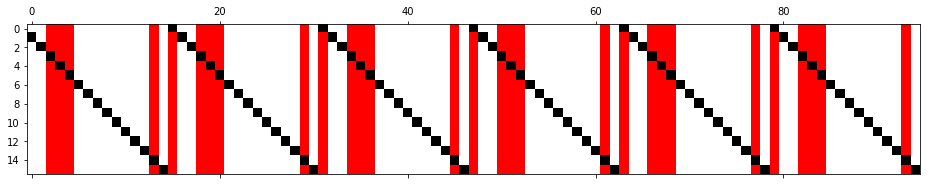

Score: 37.0:  82%|████████▎ | 165/200 [11:01<02:16,  3.91s/ episodes]

Got new port for ns3gm interface:  5753


Score: 37.0:  82%|████████▎ | 165/200 [11:05<02:16,  3.91s/ episodes]

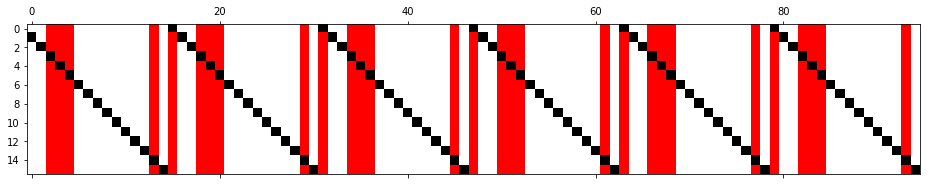

Score: 37.0:  83%|████████▎ | 166/200 [11:05<02:12,  3.90s/ episodes]

Got new port for ns3gm interface:  7581


Score: 37.0:  83%|████████▎ | 166/200 [11:09<02:12,  3.90s/ episodes]

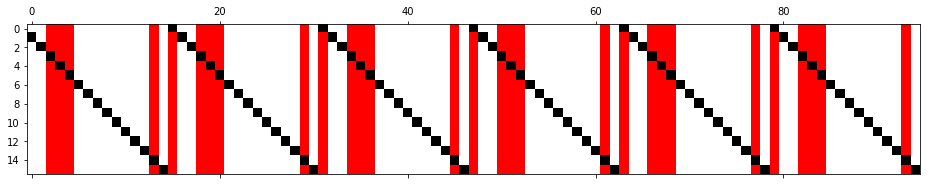

Score: 37.0:  84%|████████▎ | 167/200 [11:09<02:08,  3.90s/ episodes]

Got new port for ns3gm interface:  7446


Score: 37.0:  84%|████████▎ | 167/200 [11:13<02:08,  3.90s/ episodes]

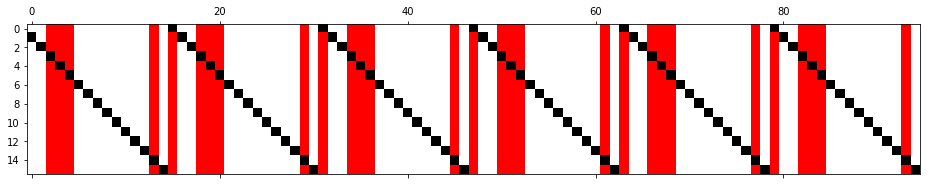

Score: 37.0:  84%|████████▍ | 168/200 [11:13<02:04,  3.90s/ episodes]

Got new port for ns3gm interface:  5773


Score: 37.0:  84%|████████▍ | 168/200 [11:17<02:04,  3.90s/ episodes]

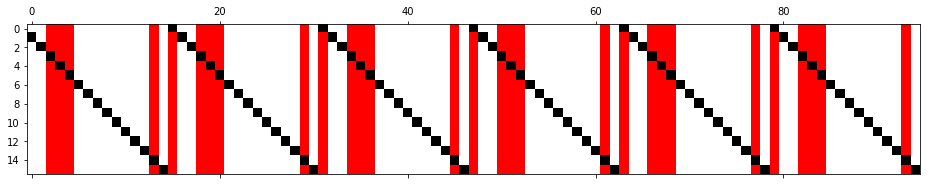

Score: 37.0:  84%|████████▍ | 169/200 [11:17<02:01,  3.91s/ episodes]

Got new port for ns3gm interface:  5115


Score: 37.0:  84%|████████▍ | 169/200 [11:21<02:01,  3.91s/ episodes]

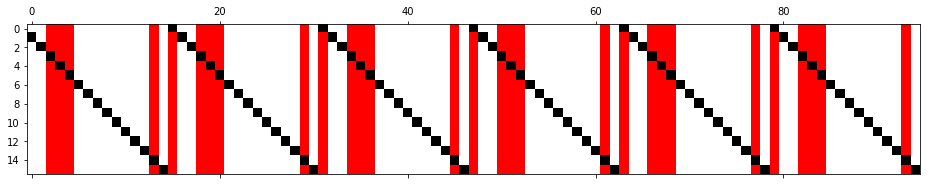

Score: 37.0:  85%|████████▌ | 170/200 [11:21<01:57,  3.91s/ episodes]

Got new port for ns3gm interface:  5108


Score: 37.0:  85%|████████▌ | 170/200 [11:25<01:57,  3.91s/ episodes]

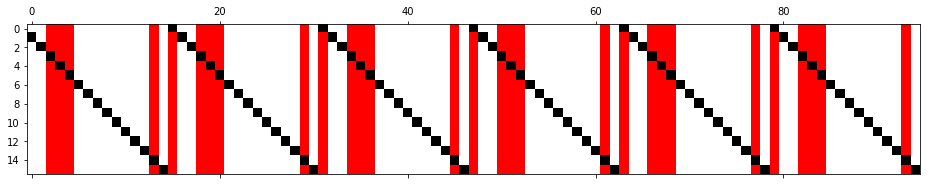

Score: 37.0:  86%|████████▌ | 171/200 [11:25<01:53,  3.91s/ episodes]

Got new port for ns3gm interface:  9348


Score: 37.0:  86%|████████▌ | 171/200 [11:29<01:53,  3.91s/ episodes]

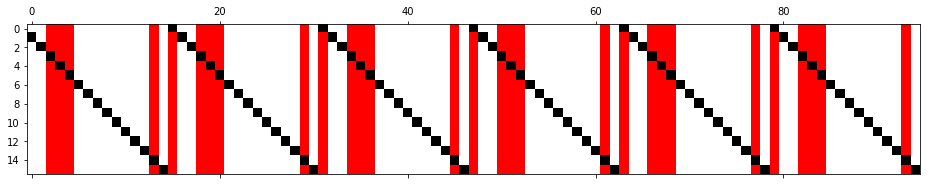

Score: 37.0:  86%|████████▌ | 172/200 [11:29<01:49,  3.92s/ episodes]

Got new port for ns3gm interface:  7778


Score: 37.0:  86%|████████▌ | 172/200 [11:33<01:49,  3.92s/ episodes]

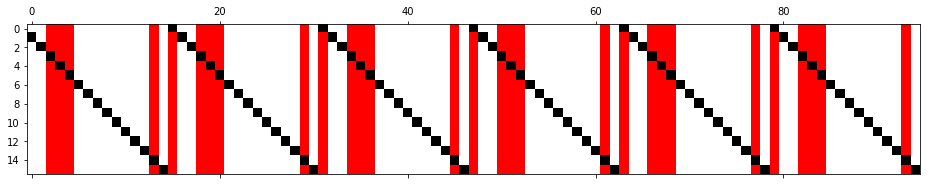

Score: 37.0:  86%|████████▋ | 173/200 [11:33<01:46,  3.94s/ episodes]

Got new port for ns3gm interface:  6307


Score: 37.0:  86%|████████▋ | 173/200 [11:36<01:46,  3.94s/ episodes]

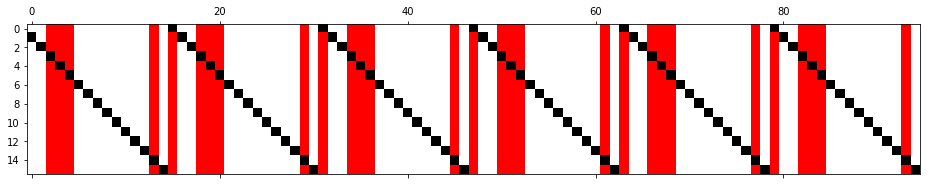

Score: 37.0:  87%|████████▋ | 174/200 [11:37<01:42,  3.94s/ episodes]

Got new port for ns3gm interface:  6463


Score: 37.0:  87%|████████▋ | 174/200 [11:40<01:42,  3.94s/ episodes]

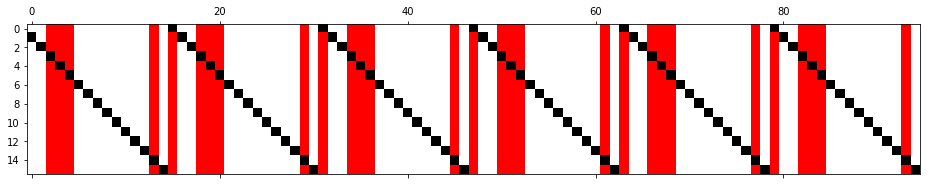

Score: 37.0:  88%|████████▊ | 175/200 [11:40<01:38,  3.94s/ episodes]

Got new port for ns3gm interface:  7149


Score: 37.0:  88%|████████▊ | 175/200 [11:44<01:38,  3.94s/ episodes]

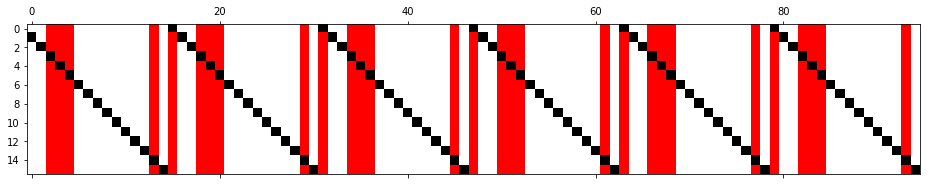

Score: 37.0:  88%|████████▊ | 176/200 [11:44<01:34,  3.93s/ episodes]

Got new port for ns3gm interface:  8453


Score: 37.0:  88%|████████▊ | 176/200 [11:48<01:34,  3.93s/ episodes]

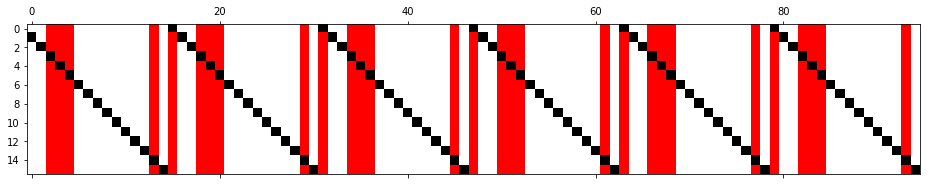

Score: 37.0:  88%|████████▊ | 177/200 [11:48<01:30,  3.93s/ episodes]

Got new port for ns3gm interface:  9335


Score: 37.0:  88%|████████▊ | 177/200 [11:52<01:30,  3.93s/ episodes]

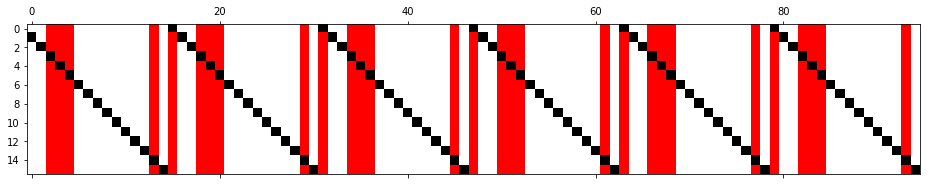

Score: 37.0:  89%|████████▉ | 178/200 [11:52<01:26,  3.92s/ episodes]

Got new port for ns3gm interface:  7781


Score: 37.0:  89%|████████▉ | 178/200 [11:56<01:26,  3.92s/ episodes]

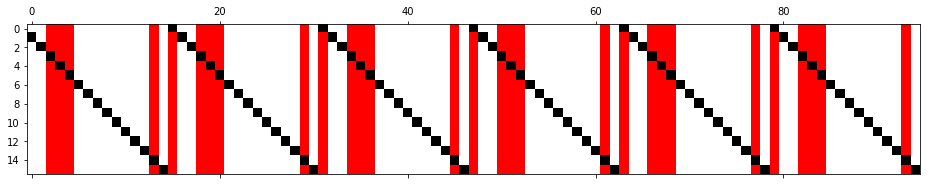

Score: 37.0:  90%|████████▉ | 179/200 [11:56<01:22,  3.93s/ episodes]

Got new port for ns3gm interface:  7473


Score: 37.0:  90%|████████▉ | 179/200 [12:00<01:22,  3.93s/ episodes]

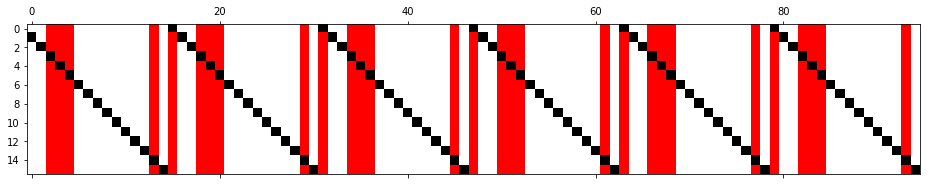

Score: 37.0:  90%|█████████ | 180/200 [12:00<01:19,  3.95s/ episodes]

Got new port for ns3gm interface:  8304


Score: 37.0:  90%|█████████ | 180/200 [12:04<01:19,  3.95s/ episodes]

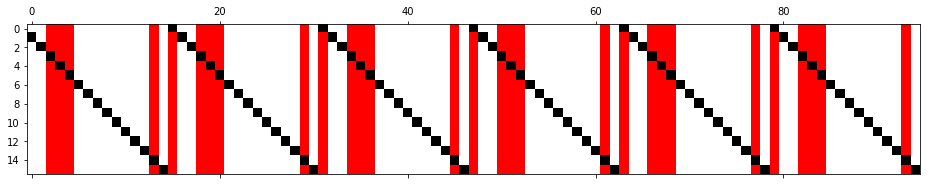

Score: 37.0:  90%|█████████ | 181/200 [12:04<01:15,  3.95s/ episodes]

Got new port for ns3gm interface:  8185


Score: 37.0:  90%|█████████ | 181/200 [12:08<01:15,  3.95s/ episodes]

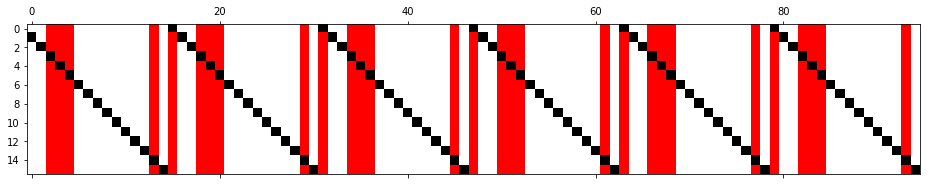

Score: 37.0:  91%|█████████ | 182/200 [12:08<01:11,  3.94s/ episodes]

Got new port for ns3gm interface:  7871


Score: 37.0:  91%|█████████ | 182/200 [12:12<01:11,  3.94s/ episodes]

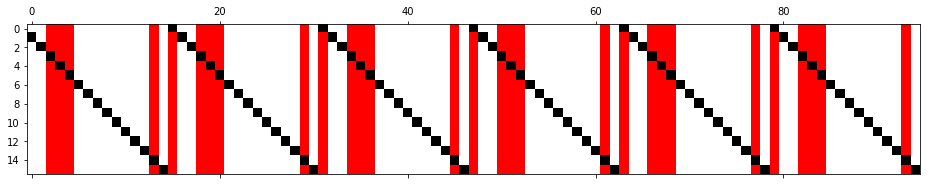

Score: 37.0:  92%|█████████▏| 183/200 [12:12<01:06,  3.94s/ episodes]

Got new port for ns3gm interface:  8653


Score: 37.0:  92%|█████████▏| 183/200 [12:16<01:06,  3.94s/ episodes]

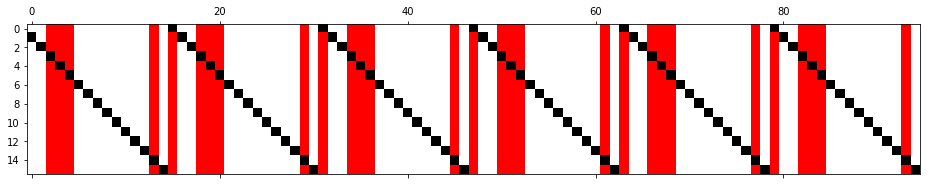

Score: 37.0:  92%|█████████▏| 184/200 [12:16<01:03,  3.94s/ episodes]

Got new port for ns3gm interface:  8563


Score: 37.0:  92%|█████████▏| 184/200 [12:20<01:03,  3.94s/ episodes]

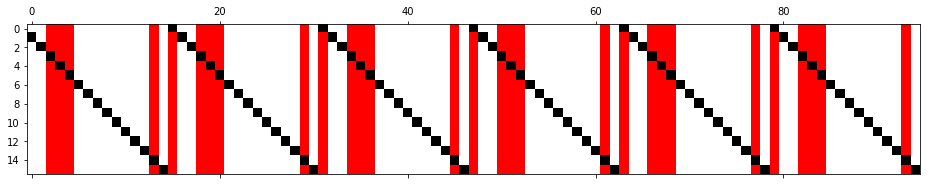

Score: 37.0:  92%|█████████▎| 185/200 [12:20<00:58,  3.93s/ episodes]

Got new port for ns3gm interface:  7636


Score: 37.0:  92%|█████████▎| 185/200 [12:24<00:58,  3.93s/ episodes]

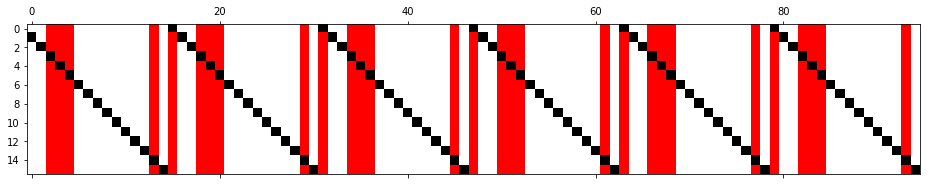

Score: 37.0:  93%|█████████▎| 186/200 [12:24<00:55,  3.93s/ episodes]

Got new port for ns3gm interface:  8639


Score: 37.0:  93%|█████████▎| 186/200 [12:28<00:55,  3.93s/ episodes]

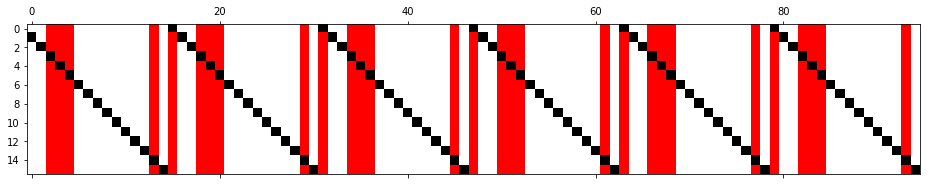

Score: 37.0:  94%|█████████▎| 187/200 [12:28<00:50,  3.92s/ episodes]

Got new port for ns3gm interface:  9346


Score: 37.0:  94%|█████████▎| 187/200 [12:32<00:50,  3.92s/ episodes]

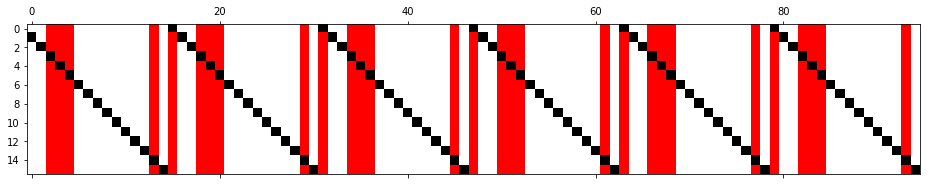

Score: 37.0:  94%|█████████▍| 188/200 [12:32<00:47,  3.93s/ episodes]

Got new port for ns3gm interface:  7572


Score: 37.0:  94%|█████████▍| 188/200 [12:35<00:47,  3.93s/ episodes]

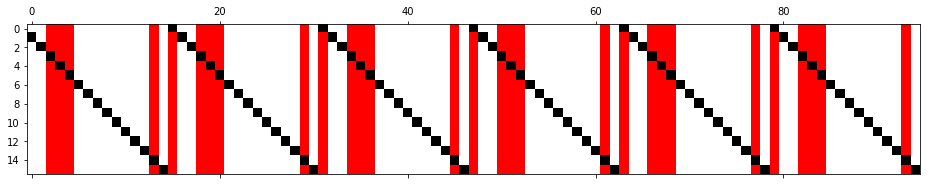

Score: 37.0:  94%|█████████▍| 189/200 [12:36<00:43,  3.93s/ episodes]

Got new port for ns3gm interface:  7434


Score: 37.0:  94%|█████████▍| 189/200 [12:39<00:43,  3.93s/ episodes]

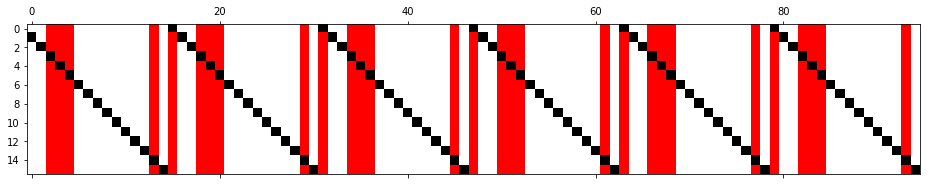

Score: 37.0:  95%|█████████▌| 190/200 [12:40<00:39,  3.93s/ episodes]

Got new port for ns3gm interface:  7089


Score: 37.0:  95%|█████████▌| 190/200 [12:43<00:39,  3.93s/ episodes]

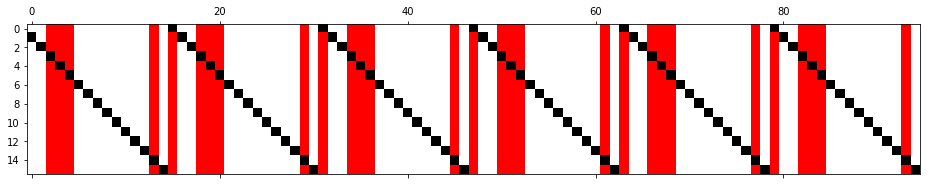

Score: 37.0:  96%|█████████▌| 191/200 [12:43<00:35,  3.94s/ episodes]

Got new port for ns3gm interface:  6701


Score: 37.0:  96%|█████████▌| 191/200 [12:47<00:35,  3.94s/ episodes]

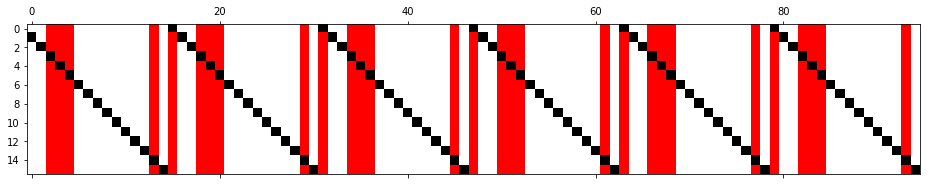

Score: 37.0:  96%|█████████▌| 192/200 [12:47<00:31,  3.93s/ episodes]

Got new port for ns3gm interface:  7132


Score: 37.0:  96%|█████████▌| 192/200 [12:51<00:31,  3.93s/ episodes]

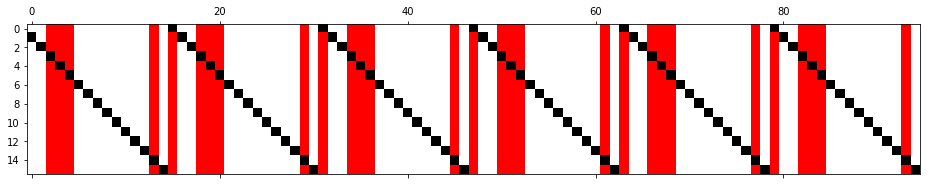

Score: 37.0:  96%|█████████▋| 193/200 [12:51<00:27,  3.94s/ episodes]

Got new port for ns3gm interface:  9619


Score: 37.0:  96%|█████████▋| 193/200 [12:55<00:27,  3.94s/ episodes]

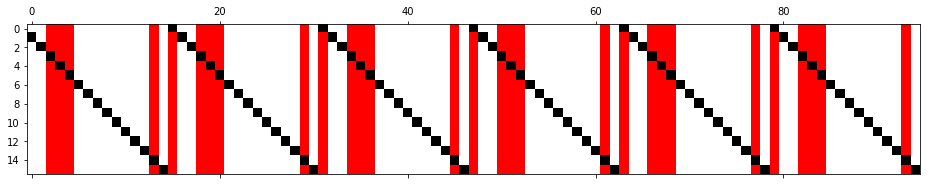

Score: 37.0:  97%|█████████▋| 194/200 [12:55<00:23,  3.93s/ episodes]

Got new port for ns3gm interface:  7014


Score: 37.0:  97%|█████████▋| 194/200 [12:59<00:23,  3.93s/ episodes]

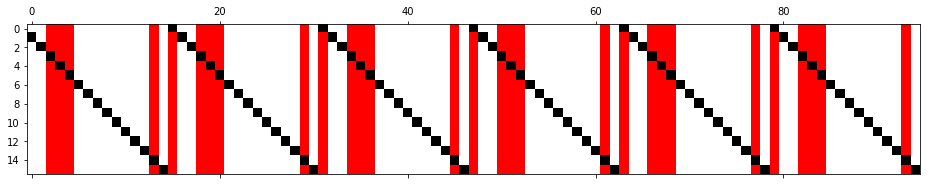

Score: 37.0:  98%|█████████▊| 195/200 [12:59<00:19,  3.94s/ episodes]

Got new port for ns3gm interface:  8343


Score: 37.0:  98%|█████████▊| 195/200 [13:03<00:19,  3.94s/ episodes]

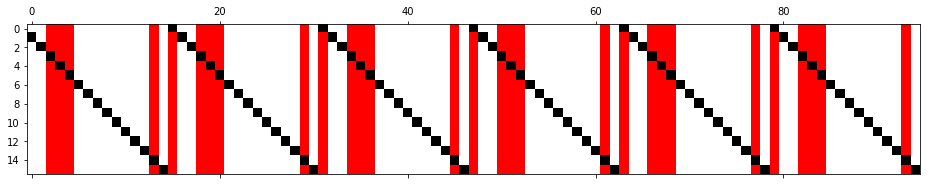

Score: 37.0:  98%|█████████▊| 196/200 [13:03<00:15,  3.93s/ episodes]

Got new port for ns3gm interface:  5451


Score: 37.0:  98%|█████████▊| 196/200 [13:07<00:15,  3.93s/ episodes]

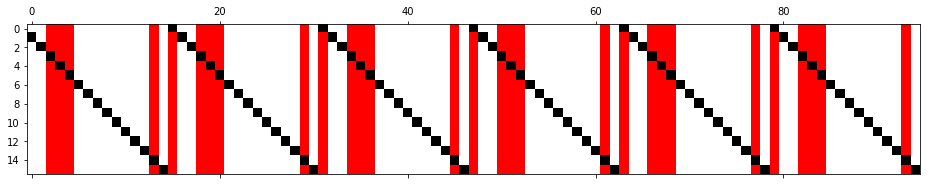

Score: 37.0:  98%|█████████▊| 197/200 [13:07<00:11,  3.93s/ episodes]

Got new port for ns3gm interface:  5735


Score: 37.0:  98%|█████████▊| 197/200 [13:11<00:11,  3.93s/ episodes]

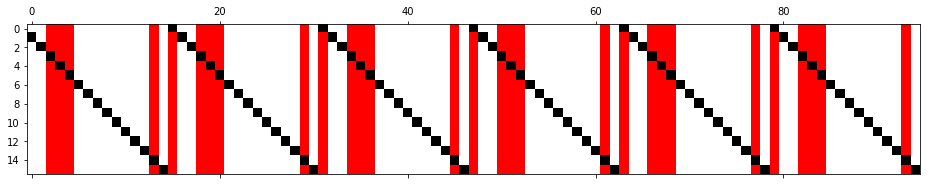

Score: 37.0:  99%|█████████▉| 198/200 [13:11<00:07,  3.94s/ episodes]

Got new port for ns3gm interface:  7160


Score: 37.0:  99%|█████████▉| 198/200 [13:15<00:07,  3.94s/ episodes]

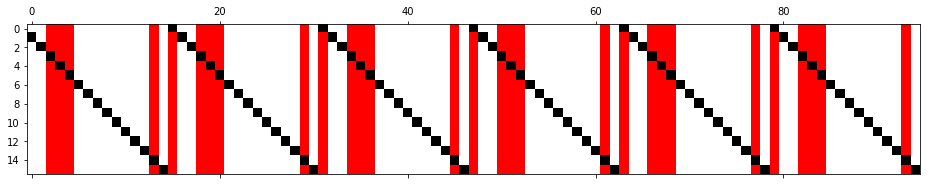

Score: 37.0: 100%|█████████▉| 199/200 [13:15<00:03,  3.94s/ episodes]

Got new port for ns3gm interface:  5362


Score: 37.0: 100%|█████████▉| 199/200 [13:19<00:03,  3.94s/ episodes]

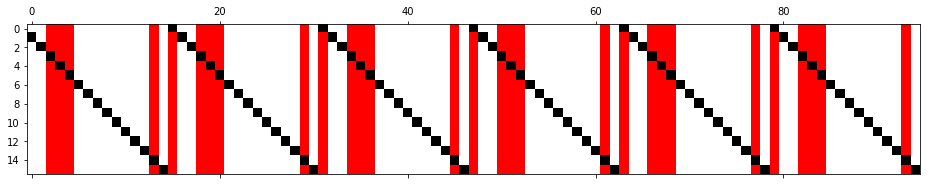

Score: 37.0: 100%|██████████| 200/200 [13:19<00:00,  3.94s/ episodes]


Plot Learning Performance


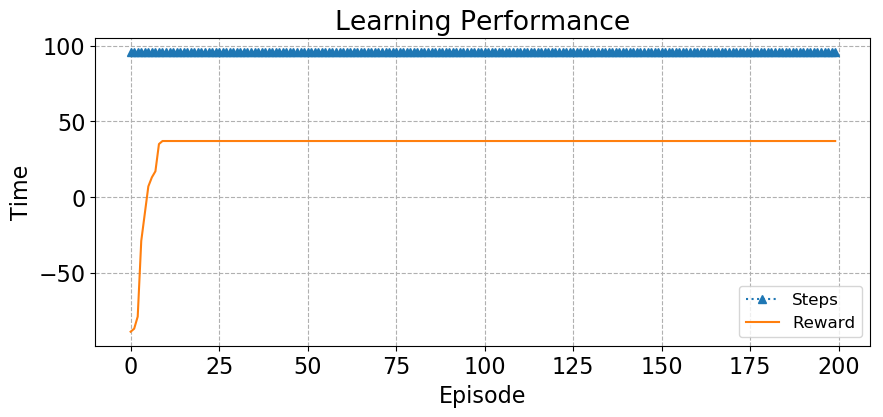

In [6]:
filename = 'DuelingDQN_withreplay_Sim_simulation_Pyscript'
stats = algo.train(env, filename)

In [7]:
#### plot the results and save it as pdf file
